# Import Libraries

In [71]:
import sys
import sqlite3
import warnings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif, RFE, SelectFromModel
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, 
                           precision_recall_fscore_support, roc_auc_score, cohen_kappa_score)
from imblearn.over_sampling import SMOTE
from scipy.stats import randint, uniform

warnings.filterwarnings('ignore')
np.random.seed(42)

# Load Database

In [72]:
sys.path.append('/home/pooya/w/DroughtMonitoringIran/')

DATABASE_PATH = "./database/database.db"

conn = sqlite3.connect(DATABASE_PATH)

data = pd.read_sql(sql='SELECT * FROM data', con=conn)

conn.close()

# Select Columns and Rows

In [73]:
# Select Drought Index and Period
di = 'SPI'
di_scale = 3

# Select Stations
# selected_stations = ['Ramsar', 'Nowshahr', 'Siahbisheh', 'Kiyasar', 'Kojur', 'Baladeh', 'Alasht', 'Babolsar', 'Gharakhil', 'Sari', 'Sari (dasht-e-naz airport)', 'Galugah', 'Bandar-e-amirabad', 'Amol', 'Polsefid']
# selected_stations = ['Ramsar', 'Nowshahr']
# selected_stations = ['Siahbisheh', 'Kiyasar', 'Kojur', 'Baladeh', 'Alasht']
selected_stations = ['Babolsar', 'Gharakhil', 'Sari', 'Sari (dasht-e-naz airport)', 'Galugah', 'Bandar-e-amirabad', 'Amol', 'Polsefid']

# Select Columns
selected_columns = [
    'Station_Name', 'Station_ID',
    'Station_Latitude', 'Station_Longitude', 'Station_Elevation',
    'Date',
    f'{di}_{di_scale}',
    f'GPM_{di}_{di_scale}',
    f'ERA5_{di}_{di_scale}',
    'ERA5_Precipitation',
    'GPM_Precipitation',
    'TRMM_Precipitation',
    'TERRACLIMATE_Precipitation',
    'PERSIANNCDR_Precipitation',
    'PET_MOD16A2GF',
    'NDVI', 'EVI',
    'LSTDay', 'LSTNight', 'LST',
    'PCI_GPM', 'PCI_ERA5',
    'VCI', 'TCI', 'VHI',
    'CI_GPM', 'CI_ERA5',
]

# Select Start and End Date
start_date = '2006-09'
end_date = '2023-10'

# Filter Data

In [74]:
df = data\
    .filter(items=selected_columns)\
        .query("Station_Name in @selected_stations and Date >= @start_date and Date < @end_date")

# Add Some Columns

In [75]:
# Date, Year, Month
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m')
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# SPI and SPEI Class
df[f'{di}_{di_scale}_Class'] = pd.cut(df[f'{di}_{di_scale}'], bins=[-10, -2, -1.5, -1, 1, 1.5, 2, 10], labels=['ED', 'SD', 'MD', 'NN', 'MW', 'VW', 'EW'])

# Month Sin & Cos
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
        
# LST Diff
df['LST_Diff'] = df['LSTDay'] - df['LSTNight']

# Convert to Category
df['Station_ID'] = df['Station_ID'].astype('category')
df['Year'] = df['Year'].astype('category')
df['Month'] = df['Month'].astype('category')
df[f'{di}_{di_scale}_Class'] = df[f'{di}_{di_scale}_Class'].astype('category')

In [76]:
df.dropna(inplace=True)
df.sort_values(by=['Station_ID', 'Year', 'Month'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [67]:
selected_columns_lag_roll = [
    'ERA5_Precipitation',
    'GPM_Precipitation',
    'TRMM_Precipitation',
    'TERRACLIMATE_Precipitation',
    'PERSIANNCDR_Precipitation',
    f'GPM_{di}_{di_scale}',
    f'ERA5_{di}_{di_scale}',
    'PET_MOD16A2GF',
    'NDVI', 'EVI',
    'LSTDay', 'LSTNight', 'LST',
    'PCI_GPM', 'PCI_ERA5',
    'VCI', 'TCI', 'VHI',
    'CI_GPM', 'CI_ERA5',
]

# Add Lag
for lag in range(1, 4):
    for col in selected_columns_lag_roll:
        df[f'{col}_lag_{lag}'] = df.groupby('Station_ID', observed=False)[col].shift(lag)


# Add Mean and Std Roll
for r in [3]:
    for col in selected_columns_lag_roll:
        df[f'{col}_roll_mean_{r}'] = df.groupby('Station_ID', observed=False)[col].transform(lambda x: x.rolling(window=r, min_periods=1).mean())
        df[f'{col}_roll_std_{r}'] = df.groupby('Station_ID', observed=False)[col].transform(lambda x: x.rolling(window=r, min_periods=1).std())

# Remove all NA

In [68]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# Model: Claude

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Machine Learning imports
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, RFE, SelectFromModel
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, 
                           precision_recall_fscore_support, roc_auc_score, roc_curve,
                           precision_recall_curve, average_precision_score)
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Advanced hyperparameter optimization
try:
    from skopt import BayesSearchCV
    from skopt.space import Real, Integer
    BAYES_AVAILABLE = True
except ImportError:
    BAYES_AVAILABLE = False
    print("scikit-optimize not available. Using RandomizedSearchCV instead.")

# Plotting setup
plt.style.use('default')
sns.set_palette("husl")

class SPI_GradientBoostingPredictor:
    """
    Comprehensive f'{di}_{di_scale}_Class' prediction using Gradient Boosting
    with feature selection, hyperparameter tuning, SMOTE, and extensive evaluation
    """
    
    def __init__(self, data, target_col=f'{di}_{di_scale}_Class', test_size=0.2, random_state=42):
        self.data = data.copy()
        self.target_col = target_col
        self.test_size = test_size
        self.random_state = random_state
        self.label_encoder = LabelEncoder()
        self.scaler = StandardScaler()
        self.feature_names = None
        self.selected_features = None
        self.best_model = None
        self.results = {}
        
    def prepare_data(self):
        """Prepare data for modeling with station-wise standardization"""
        print("🔄 Preparing data...")
        
        # Define features to exclude from modeling
        exclude_features = [
            'Station_Name', 'Station_ID', 'Date', f'{di}_{di_scale}_Class', f'{di}_{di_scale}',  # Target and identifiers
        ]
        
        # Features to exclude from standardization (categorical/already processed)
        no_standardize_features = [
            'Station_Latitude', 'Station_Longitude', 'Station_Elevation',
            'Year', 'Month', 'Month_sin', 'Month_cos'
        ]
        
        # Get feature columns
        feature_cols = [col for col in self.data.columns if col not in exclude_features]
        self.feature_names = feature_cols
        
        # Separate features for standardization
        standardize_features = [col for col in feature_cols if col not in no_standardize_features]
        keep_as_is_features = [col for col in feature_cols if col in no_standardize_features]
        
        print(f"📊 Total features: {len(feature_cols)}")
        print(f"🔧 Features to standardize per station: {len(standardize_features)}")
        print(f"📍 Features to keep as-is: {len(keep_as_is_features)}")
        
        # Prepare features and target
        X = self.data[feature_cols].copy()
        y = self.data[self.target_col].copy()
        
        # # Handle missing values before standardization
        # print("🔧 Handling missing values...")
        # X = X.fillna(X.median())
        
        # Station-wise standardization
        print("📊 Performing station-wise standardization...")
        X_standardized = X.copy()
        
        # Get unique stations
        stations = self.data['Station_ID'].unique()
        print(f"🏢 Processing {len(stations)} stations")
        
        # Store standardization parameters for each station
        self.station_scalers = {}
        
        for station_id in stations:
            # Get station mask
            station_mask = self.data['Station_ID'] == station_id
            
            # Standardize only the specified features for this station
            if len(standardize_features) > 0:
                # Create scaler for this station
                station_scaler = StandardScaler()
                
                # Fit and transform the standardizable features for this station
                station_data = X_standardized.loc[station_mask, standardize_features]
                
                if len(station_data) > 1:  # Need at least 2 samples for standardization
                    standardized_data = station_scaler.fit_transform(station_data)
                    X_standardized.loc[station_mask, standardize_features] = standardized_data
                    
                    # Store scaler for this station
                    self.station_scalers[station_id] = station_scaler
                else:
                    print(f"⚠️  Station {station_id} has only {len(station_data)} sample(s), skipping standardization")
        
        print("✅ Station-wise standardization completed")
        
        # Encode target variable
        y_encoded = self.label_encoder.fit_transform(y)
        
        # Create train/test split while preserving station distribution
        print("🔀 Creating stratified train/test split...")
        
        # Create a combined stratification key (station + class)
        station_class_key = self.data['Station_ID'].astype(str) + '_' + y.astype(str)
        
        try:
            # Try stratified split with station-class combination
            self.X_train, self.X_test, self.y_train, self.y_test, self.train_indices, self.test_indices = train_test_split(
                X_standardized, y_encoded, self.data.index, 
                test_size=self.test_size, random_state=self.random_state,
                stratify=station_class_key
            )
        except ValueError:
            # Fallback to class-only stratification if station-class is too granular
            print("⚠️  Station-class stratification failed, using class-only stratification")
            self.X_train, self.X_test, self.y_train, self.y_test, self.train_indices, self.test_indices = train_test_split(
                X_standardized, y_encoded, self.data.index,
                test_size=self.test_size, random_state=self.random_state,
                stratify=y_encoded
            )
        
        # Store station information for train/test sets
        self.train_stations = self.data.loc[self.train_indices, 'Station_ID']
        self.test_stations = self.data.loc[self.test_indices, 'Station_ID']
        
        print(f"✅ Data prepared: {len(self.X_train)} training, {len(self.X_test)} test samples")
        print(f"📊 Training stations: {len(self.train_stations.unique())} unique stations")
        print(f"📊 Test stations: {len(self.test_stations.unique())} unique stations")
        print(f"🎯 Classes: {list(self.label_encoder.classes_)}")
        
        # Display standardization summary
        self.display_standardization_summary()
        
        return self.X_train, self.X_test, self.y_train, self.y_test
    
    def display_standardization_summary(self):
        """Display summary of standardization effects"""
        print("\n📈 STANDARDIZATION SUMMARY")
        print("=" * 40)
        
        # Sample a few features to show before/after stats
        sample_features = [col for col in self.feature_names if 'Precipitation' in col or 'LST' in col][:5]
        
        if sample_features:
            print(f"Sample of {len(sample_features)} features showing standardization effect:")
            print("-" * 70)
            
            for feature in sample_features:
                if feature in self.X_train.columns:
                    train_mean = self.X_train[feature].mean()
                    train_std = self.X_train[feature].std()
                    print(f"{feature[:30]:30} | Mean: {train_mean:8.3f} | Std: {train_std:8.3f}")
        
        print(f"\n🏢 Station scalers created: {len(self.station_scalers)}")
        print("✅ Each station's features are now standardized to mean=0, std=1")
    
    def feature_selection(self, n_features_to_select=50):
        """Comprehensive feature selection using multiple methods"""
        print(f"🔍 Performing feature selection (selecting top {n_features_to_select} features)...")
        
        # Method 1: Univariate feature selection
        selector_univariate = SelectKBest(score_func=f_classif, k=min(n_features_to_select, len(self.feature_names)))
        X_train_univariate = selector_univariate.fit_transform(self.X_train, self.y_train)
        univariate_features = [self.feature_names[i] for i in selector_univariate.get_support(indices=True)]
        
        # Method 2: Recursive Feature Elimination with basic GB
        base_estimator = GradientBoostingClassifier(n_estimators=50, random_state=self.random_state)
        selector_rfe = RFE(estimator=base_estimator, n_features_to_select=min(n_features_to_select, len(self.feature_names)))
        selector_rfe.fit(self.X_train, self.y_train)
        rfe_features = [self.feature_names[i] for i in selector_rfe.get_support(indices=True)]
        
        # Method 3: Feature importance from model
        base_estimator.fit(self.X_train, self.y_train)
        selector_model = SelectFromModel(estimator=base_estimator, max_features=n_features_to_select)
        selector_model.fit(self.X_train, self.y_train)
        model_features = [self.feature_names[i] for i in selector_model.get_support(indices=True)]
        
        # Combine features from all methods
        combined_features = list(set(univariate_features + rfe_features + model_features))
        
        # If we have more features than desired, rank by importance
        if len(combined_features) > n_features_to_select:
            feature_importance_scores = {}
            for feature in combined_features:
                if feature in self.feature_names:
                    idx = self.feature_names.index(feature)
                    feature_importance_scores[feature] = base_estimator.feature_importances_[idx]
            
            # Select top features by importance
            sorted_features = sorted(feature_importance_scores.items(), key=lambda x: x[1], reverse=True)
            self.selected_features = [feature for feature, _ in sorted_features[:n_features_to_select]]
        else:
            self.selected_features = combined_features
        
        print(f"✅ Selected {len(self.selected_features)} features")
        print(f"🔝 Top 10 features: {self.selected_features[:10]}")
        
        # Update training and test data with selected features
        self.X_train_selected = self.X_train[self.selected_features]
        self.X_test_selected = self.X_test[self.selected_features]
        
        return self.selected_features
    
    def define_hyperparameter_space(self):
        """Define hyperparameter search spaces for Gradient Boosting"""
        print("🔧 Defining hyperparameter search spaces...")
        
        if BAYES_AVAILABLE:
            # BayesSearchCV parameter space
            self.param_space = {
                'classifier__n_estimators': [50, 100, 200, 300, 500],
                'classifier__max_depth': [3, 5, 7, 10, 15],
                'classifier__min_samples_split': [2, 5, 10, 15, 20],
                'classifier__min_samples_leaf': [1, 2, 5, 10],
                'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
                'classifier__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
                'classifier__max_features': ['sqrt', 'log2', None],
            }
        else:
            # RandomizedSearchCV parameter space
            self.param_space = {
                'classifier__n_estimators': [50, 100, 200, 300, 500],
                'classifier__max_depth': [3, 5, 7, 10, 15],
                'classifier__min_samples_split': [2, 5, 10, 15, 20],
                'classifier__min_samples_leaf': [1, 2, 5, 10],
                'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
                'classifier__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
                'classifier__max_features': ['sqrt', 'log2', None],
            }
        
        print("✅ Hyperparameter spaces defined")
        return self.param_space
    
    def hyperparameter_tuning(self, n_iter=50, cv_folds=5):
        """Perform hyperparameter tuning with SMOTE"""
        print(f"🎯 Starting hyperparameter tuning with {'BayesSearchCV' if BAYES_AVAILABLE else 'RandomizedSearchCV'}...")
        
        # Create pipeline with SMOTE and Gradient Boosting
        pipeline = ImbPipeline([
            ('smote', SMOTE(random_state=self.random_state)),
            ('classifier', GradientBoostingClassifier(random_state=self.random_state))
        ])
        
        # Cross-validation strategy
        cv_strategy = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=self.random_state)
        
        # Choose search method
        if BAYES_AVAILABLE:
            search = BayesSearchCV(
                pipeline,
                self.param_space,
                n_iter=n_iter,
                cv=cv_strategy,
                scoring='f1_macro',
                n_jobs=-1,
                random_state=self.random_state,
                verbose=1
            )
        else:
            search = RandomizedSearchCV(
                pipeline,
                self.param_space,
                n_iter=n_iter,
                cv=cv_strategy,
                scoring='f1_macro',
                n_jobs=-1,
                random_state=self.random_state,
                verbose=1
            )
        
        # Fit the search
        search.fit(self.X_train_selected, self.y_train)
        
        self.best_model = search.best_estimator_
        self.search_results = search
        
        print("✅ Hyperparameter tuning completed")
        print(f"🏆 Best F1-macro score: {search.best_score_:.4f}")
        print(f"🔧 Best parameters: {search.best_params_}")
        
        return self.best_model
    
    def evaluate_model(self):
        """Comprehensive model evaluation"""
        print("📊 Evaluating model performance...")
        
        # Predictions
        y_train_pred = self.best_model.predict(self.X_train_selected)
        y_test_pred = self.best_model.predict(self.X_test_selected)
        
        # Prediction probabilities
        y_train_proba = self.best_model.predict_proba(self.X_train_selected)
        y_test_proba = self.best_model.predict_proba(self.X_test_selected)
        
        # Calculate metrics
        train_accuracy = accuracy_score(self.y_train, y_train_pred)
        test_accuracy = accuracy_score(self.y_test, y_test_pred)
        
        train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(
            self.y_train, y_train_pred, average='macro'
        )
        test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
            self.y_test, y_test_pred, average='macro'
        )
        
        # Multi-class ROC AUC (ovr = one-vs-rest)
        try:
            train_roc_auc = roc_auc_score(self.y_train, y_train_proba, multi_class='ovr')
            test_roc_auc = roc_auc_score(self.y_test, y_test_proba, multi_class='ovr')
        except:
            train_roc_auc = test_roc_auc = None
        
        # Store results
        self.results = {
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy,
            'train_precision': train_precision,
            'test_precision': test_precision,
            'train_recall': train_recall,
            'test_recall': test_recall,
            'train_f1': train_f1,
            'test_f1': test_f1,
            'train_roc_auc': train_roc_auc,
            'test_roc_auc': test_roc_auc,
            'y_train_pred': y_train_pred,
            'y_test_pred': y_test_pred,
            'y_train_proba': y_train_proba,
            'y_test_proba': y_test_proba,
            'feature_importance': self.get_feature_importance(),
            'classification_report_train': classification_report(self.y_train, y_train_pred, 
                                                               target_names=self.label_encoder.classes_),
            'classification_report_test': classification_report(self.y_test, y_test_pred, 
                                                              target_names=self.label_encoder.classes_)
        }
        
        print("✅ Model evaluation completed")
        return self.results
    
    def get_feature_importance(self):
        """Get feature importance scores"""
        # Get built-in feature importance
        gb_classifier = self.best_model.named_steps['classifier']
        importance_scores = gb_classifier.feature_importances_
        
        # Create feature importance dataframe
        feature_importance_df = pd.DataFrame({
            'feature': self.selected_features,
            'importance': importance_scores
        }).sort_values('importance', ascending=False)
        
        return feature_importance_df
    
    def generate_summary(self):
        """Generate comprehensive model summary"""
        print("📋 Generating comprehensive summary...")
        
        summary = {
            'model_info': {
                'model_type': 'Gradient Boosting Classifier',
                'optimization_method': 'BayesSearchCV' if BAYES_AVAILABLE else 'RandomizedSearchCV',
                'smote_applied': True,
                'n_features_selected': len(self.selected_features),
                'n_classes': len(self.label_encoder.classes_),
                'classes': list(self.label_encoder.classes_)
            },
            'data_info': {
                'total_samples': len(self.data),
                'train_samples': len(self.X_train),
                'test_samples': len(self.X_test),
                'train_test_split': f"{1-self.test_size:.0%}/{self.test_size:.0%}",
                'original_features': len(self.feature_names)
            },
            'performance_metrics': {
                'train_accuracy': f"{self.results['train_accuracy']:.4f}",
                'test_accuracy': f"{self.results['test_accuracy']:.4f}",
                'train_f1_macro': f"{self.results['train_f1']:.4f}",
                'test_f1_macro': f"{self.results['test_f1']:.4f}",
                'train_precision_macro': f"{self.results['train_precision']:.4f}",
                'test_precision_macro': f"{self.results['test_precision']:.4f}",
                'train_recall_macro': f"{self.results['train_recall']:.4f}",
                'test_recall_macro': f"{self.results['test_recall']:.4f}",
            },
            'best_hyperparameters': self.search_results.best_params_,
            'top_features': self.results['feature_importance'].head(15).to_dict('records')
        }
        
        if self.results['train_roc_auc'] is not None:
            summary['performance_metrics']['train_roc_auc'] = f"{self.results['train_roc_auc']:.4f}"
            summary['performance_metrics']['test_roc_auc'] = f"{self.results['test_roc_auc']:.4f}"
        
        print("✅ Summary generated")
        return summary
    
    def create_visualizations(self):
        """Create comprehensive visualizations"""
        print("📈 Creating comprehensive visualizations...")
        
        # Set up the plotting area
        fig = plt.figure(figsize=(24, 28))
        
        # 1. Feature Importance Plot
        ax1 = plt.subplot(5, 3, 1)
        top_features = self.results['feature_importance'].head(20)
        sns.barplot(data=top_features, y='feature', x='importance', palette='viridis', ax=ax1)
        ax1.set_title('Top 20 Feature Importance', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Importance Score')
        ax1.tick_params(axis='y', labelsize=8)
        
        # 2. Training Confusion Matrix
        ax2 = plt.subplot(5, 3, 2)
        train_cm = confusion_matrix(self.y_train, self.results['y_train_pred'])
        sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=self.label_encoder.classes_,
                    yticklabels=self.label_encoder.classes_, ax=ax2)
        ax2.set_title('Training Confusion Matrix', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Predicted')
        ax2.set_ylabel('Actual')
        
        # 3. Test Confusion Matrix
        ax3 = plt.subplot(5, 3, 3)
        test_cm = confusion_matrix(self.y_test, self.results['y_test_pred'])
        sns.heatmap(test_cm, annot=True, fmt='d', cmap='Oranges',
                    xticklabels=self.label_encoder.classes_,
                    yticklabels=self.label_encoder.classes_, ax=ax3)
        ax3.set_title('Test Confusion Matrix', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Predicted')
        ax3.set_ylabel('Actual')
        
        # 4. Class Distribution
        ax4 = plt.subplot(5, 3, 4)
        class_counts = pd.Series(self.y_train).value_counts().sort_index()
        class_names = [self.label_encoder.classes_[i] for i in class_counts.index]
        colors = plt.cm.Set3(np.linspace(0, 1, len(class_names)))
        ax4.pie(class_counts.values, labels=class_names, autopct='%1.1f%%', colors=colors)
        ax4.set_title('Training Set Class Distribution', fontsize=14, fontweight='bold')
        
        # 5. Performance Metrics Comparison
        ax5 = plt.subplot(5, 3, 5)
        metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
        train_scores = [self.results['train_accuracy'], self.results['train_precision'], 
                       self.results['train_recall'], self.results['train_f1']]
        test_scores = [self.results['test_accuracy'], self.results['test_precision'],
                      self.results['test_recall'], self.results['test_f1']]
        
        x = np.arange(len(metrics))
        width = 0.35
        ax5.bar(x - width/2, train_scores, width, label='Train', color='skyblue', alpha=0.8)
        ax5.bar(x + width/2, test_scores, width, label='Test', color='lightcoral', alpha=0.8)
        ax5.set_xlabel('Metrics')
        ax5.set_ylabel('Score')
        ax5.set_title('Performance Metrics Comparison', fontsize=14, fontweight='bold')
        ax5.set_xticks(x)
        ax5.set_xticklabels(metrics)
        ax5.legend()
        ax5.grid(True, alpha=0.3)
        
        # 6. Station Distribution in Train/Test
        ax6 = plt.subplot(5, 3, 6)
        train_station_counts = self.train_stations.value_counts()
        test_station_counts = self.test_stations.value_counts()
        
        # Plot station distribution
        stations = sorted(set(train_station_counts.index) | set(test_station_counts.index))
        train_counts = [train_station_counts.get(s, 0) for s in stations]
        test_counts = [test_station_counts.get(s, 0) for s in stations]
        
        x_pos = np.arange(len(stations))
        ax6.bar(x_pos - 0.4, train_counts, 0.8, label='Train', alpha=0.7, color='skyblue')
        ax6.bar(x_pos + 0.4, test_counts, 0.8, label='Test', alpha=0.7, color='lightcoral')
        ax6.set_title('Station Distribution in Train/Test Sets', fontsize=14, fontweight='bold')
        ax6.set_xlabel('Station ID')
        ax6.set_ylabel('Number of Samples')
        ax6.set_xticks(x_pos)
        ax6.set_xticklabels([f'S{s}' for s in stations], rotation=45, fontsize=8)
        ax6.legend()
        ax6.grid(True, alpha=0.3)
        
        # 7. Standardization Effect Visualization
        ax7 = plt.subplot(5, 3, 7)
        # Show before/after standardization for a sample feature
        sample_feature = None
        for feature in ['ERA5_Precipitation', 'GPM_Precipitation', 'LSTDay', 'NDVI']:
            if feature in self.data.columns:
                sample_feature = feature
                break
        
        if sample_feature:
            # Get original data for comparison
            original_data = []
            standardized_data = []
            station_labels = []
            
            for station in self.data['Station_ID'].unique()[:10]:  # Show first 10 stations
                station_mask = self.data['Station_ID'] == station
                if station_mask.sum() > 5:  # Only if station has enough data
                    orig_values = self.data.loc[station_mask, sample_feature].dropna()
                    if len(orig_values) > 0:
                        original_data.extend(orig_values.tolist())
                        station_labels.extend([f'S{station}'] * len(orig_values))
            
            if original_data:
                # Create box plot
                data_for_plot = pd.DataFrame({
                    'Values': original_data,
                    'Station': station_labels
                })
                sns.boxplot(data=data_for_plot, x='Station', y='Values', ax=ax7)
                ax7.set_title(f'Feature Distribution by Station\n({sample_feature})', 
                            fontsize=12, fontweight='bold')
                ax7.tick_params(axis='x', rotation=45, labelsize=8)
        else:
            ax7.text(0.5, 0.5, 'No suitable feature for visualization', 
                    ha='center', va='center', transform=ax7.transAxes)
            ax7.set_title('Station-wise Feature Distribution', fontsize=12, fontweight='bold')
        
        # 8. Prediction Distribution (Train)
        ax8 = plt.subplot(5, 3, 8)
        train_pred_counts = pd.Series(self.results['y_train_pred']).value_counts().sort_index()
        train_pred_names = [self.label_encoder.classes_[i] for i in train_pred_counts.index]
        ax8.bar(train_pred_names, train_pred_counts.values, color='lightblue', alpha=0.7)
        ax8.set_title('Training Predictions Distribution', fontsize=14, fontweight='bold')
        ax8.set_xlabel('Predicted Class')
        ax8.set_ylabel('Count')
        ax8.tick_params(axis='x', rotation=45)
        
        # 9. Prediction Distribution (Test)
        ax9 = plt.subplot(5, 3, 9)
        test_pred_counts = pd.Series(self.results['y_test_pred']).value_counts().sort_index()
        test_pred_names = [self.label_encoder.classes_[i] for i in test_pred_counts.index]
        ax9.bar(test_pred_names, test_pred_counts.values, color='lightcoral', alpha=0.7)
        ax9.set_title('Test Predictions Distribution', fontsize=14, fontweight='bold')
        ax9.set_xlabel('Predicted Class')
        ax9.set_ylabel('Count')
        ax9.tick_params(axis='x', rotation=45)
        
        # 10. Feature Correlation Heatmap (top features)
        ax10 = plt.subplot(5, 3, 10)
        top_10_features = self.results['feature_importance'].head(10)['feature'].values
        corr_matrix = self.X_train_selected[top_10_features].corr()
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                    square=True, ax=ax10, cbar_kws={'shrink': 0.8})
        ax10.set_title('Top 10 Features Correlation\n(After Standardization)', fontsize=12, fontweight='bold')
        ax10.tick_params(axis='both', labelsize=8)
        
        # 11. ROC Curves (if available)
        ax11 = plt.subplot(5, 3, 11)
        if self.results['test_roc_auc'] is not None:
            # Plot ROC curve for each class (One-vs-Rest)
            n_classes = len(self.label_encoder.classes_)
            colors = plt.cm.Set1(np.linspace(0, 1, n_classes))
            
            for i, (class_name, color) in enumerate(zip(self.label_encoder.classes_, colors)):
                # Create binary labels for current class
                y_test_binary = (self.y_test == i).astype(int)
                y_proba_class = self.results['y_test_proba'][:, i]
                
                fpr, tpr, _ = roc_curve(y_test_binary, y_proba_class)
                auc = roc_auc_score(y_test_binary, y_proba_class)
                
                ax11.plot(fpr, tpr, color=color, lw=2, 
                         label=f'{class_name} (AUC = {auc:.3f})')
            
            ax11.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.5)
            ax11.set_xlim([0.0, 1.0])
            ax11.set_ylim([0.0, 1.05])
            ax11.set_xlabel('False Positive Rate')
            ax11.set_ylabel('True Positive Rate')
            ax11.set_title('ROC Curves (One-vs-Rest)', fontsize=14, fontweight='bold')
            ax11.legend(loc="lower right", fontsize=8)
            ax11.grid(True, alpha=0.3)
        else:
            ax11.text(0.5, 0.5, 'ROC curves not available', 
                     ha='center', va='center', transform=ax11.transAxes)
            ax11.set_title('ROC Curves', fontsize=14, fontweight='bold')
        
        # 12. Precision-Recall Curves
        ax12 = plt.subplot(5, 3, 12)
        n_classes = len(self.label_encoder.classes_)
        colors = plt.cm.Set2(np.linspace(0, 1, n_classes))
        
        for i, (class_name, color) in enumerate(zip(self.label_encoder.classes_, colors)):
            y_test_binary = (self.y_test == i).astype(int)
            y_proba_class = self.results['y_test_proba'][:, i]
            
            precision, recall, _ = precision_recall_curve(y_test_binary, y_proba_class)
            avg_precision = average_precision_score(y_test_binary, y_proba_class)
            
            ax12.plot(recall, precision, color=color, lw=2,
                     label=f'{class_name} (AP = {avg_precision:.3f})')
        
        ax12.set_xlim([0.0, 1.0])
        ax12.set_ylim([0.0, 1.05])
        ax12.set_xlabel('Recall')
        ax12.set_ylabel('Precision')
        ax12.set_title('Precision-Recall Curves', fontsize=14, fontweight='bold')
        ax12.legend(loc="lower left", fontsize=8)
        ax12.grid(True, alpha=0.3)
        
        # 13. Hyperparameter Convergence (if available)
        ax13 = plt.subplot(5, 3, 13)
        if hasattr(self.search_results, 'cv_results_'):
            scores = self.search_results.cv_results_['mean_test_score']
            ax13.plot(range(1, len(scores) + 1), scores, 'b-', alpha=0.7)
            ax13.axhline(y=max(scores), color='r', linestyle='--', alpha=0.7)
            ax13.set_title('Hyperparameter Search Convergence', fontsize=14, fontweight='bold')
            ax13.set_xlabel('Iteration')
            ax13.set_ylabel('CV F1-Score')
            ax13.grid(True, alpha=0.3)
        else:
            ax13.text(0.5, 0.5, 'Convergence plot not available', 
                    ha='center', va='center', transform=ax13.transAxes)
            ax13.set_title('Hyperparameter Search Convergence', fontsize=14, fontweight='bold')
        
        # 14. Station-wise Performance Analysis
        ax14 = plt.subplot(5, 3, 14)
        # Calculate accuracy per station in test set
        station_accuracy = {}
        for station in self.test_stations.unique():
            station_mask = self.test_stations == station
            station_indices = self.test_stations[station_mask].index
            
            # Find corresponding positions in test arrays
            test_positions = [i for i, idx in enumerate(self.test_indices) if idx in station_indices]
            
            if test_positions:
                station_y_true = self.y_test[test_positions]
                station_y_pred = self.results['y_test_pred'][test_positions]
                station_acc = accuracy_score(station_y_true, station_y_pred)
                station_accuracy[station] = station_acc
        
        if station_accuracy:
            stations = list(station_accuracy.keys())
            accuracies = list(station_accuracy.values())
            
            bars = ax14.bar(range(len(stations)), accuracies, 
                           color='lightgreen', alpha=0.7)
            ax14.set_title('Test Accuracy by Station', fontsize=14, fontweight='bold')
            ax14.set_xlabel('Station ID')
            ax14.set_ylabel('Accuracy')
            ax14.set_xticks(range(len(stations)))
            ax14.set_xticklabels([f'S{s}' for s in stations], rotation=45, fontsize=8)
            ax14.set_ylim(0, 1)
            
            # Add value labels on bars
            for bar, acc in zip(bars, accuracies):
                height = bar.get_height()
                ax14.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{acc:.3f}', ha='center', va='bottom', fontsize=8)
            ax14.grid(True, alpha=0.3)
        else:
            ax14.text(0.5, 0.5, 'Station performance analysis not available', 
                     ha='center', va='center', transform=ax14.transAxes)
            ax14.set_title('Test Accuracy by Station', fontsize=14, fontweight='bold')
        
        # 15. Model Performance Summary Text
        ax15 = plt.subplot(5, 3, 15)
        ax15.axis('off')
        summary_text = f"""
            Model Performance Summary:
            ━━━━━━━━━━━━━━━━━━━━━━━━━━━

            Training Accuracy: {self.results['train_accuracy']:.4f}
            Test Accuracy: {self.results['test_accuracy']:.4f}

            Training F1-Score: {self.results['train_f1']:.4f}
            Test F1-Score: {self.results['test_f1']:.4f}

            Training Precision: {self.results['train_precision']:.4f}
            Test Precision: {self.results['test_precision']:.4f}

            Training Recall: {self.results['train_recall']:.4f}
            Test Recall: {self.results['test_recall']:.4f}

            Features Selected: {len(self.selected_features)}
            Total Classes: {len(self.label_encoder.classes_)}
            Stations in Training: {len(self.train_stations.unique())}
            Stations in Testing: {len(self.test_stations.unique())}
            Station-wise Standardization: ✓
            SMOTE Applied: ✓
        """
        
        if self.results['train_roc_auc'] is not None:
            summary_text += f"\nTrain ROC-AUC: {self.results['train_roc_auc']:.4f}"
            summary_text += f"\nTest ROC-AUC: {self.results['test_roc_auc']:.4f}"
        
        ax15.text(0.1, 0.9, summary_text, fontsize=10, fontfamily='monospace',
                 verticalalignment='top', bbox=dict(boxstyle="round,pad=0.5", 
                 facecolor="lightgray", alpha=0.8))
        
        plt.tight_layout(pad=2.0)
        plt.show()
        
        print("✅ Visualizations created")
        ax5.set_xticks(x)
        ax5.set_xticklabels(metrics)
        ax5.legend()
        ax5.grid(True, alpha=0.3)
        
        # 6. Hyperparameter Convergence (if available)
        ax6 = plt.subplot(4, 3, 6)
        if hasattr(self.search_results, 'cv_results_'):
            scores = self.search_results.cv_results_['mean_test_score']
            ax6.plot(range(1, len(scores) + 1), scores, 'b-', alpha=0.7)
            ax6.axhline(y=max(scores), color='r', linestyle='--', alpha=0.7)
            ax6.set_title('Hyperparameter Search Convergence', fontsize=14, fontweight='bold')
            ax6.set_xlabel('Iteration')
            ax6.set_ylabel('CV F1-Score')
            ax6.grid(True, alpha=0.3)
        else:
            ax6.text(0.5, 0.5, 'Convergence plot not available', 
                    ha='center', va='center', transform=ax6.transAxes)
            ax6.set_title('Hyperparameter Search Convergence', fontsize=14, fontweight='bold')
        
        # 7. Prediction Distribution (Train)
        ax7 = plt.subplot(4, 3, 7)
        train_pred_counts = pd.Series(self.results['y_train_pred']).value_counts().sort_index()
        train_pred_names = [self.label_encoder.classes_[i] for i in train_pred_counts.index]
        ax7.bar(train_pred_names, train_pred_counts.values, color='lightblue', alpha=0.7)
        ax7.set_title('Training Predictions Distribution', fontsize=14, fontweight='bold')
        ax7.set_xlabel('Predicted Class')
        ax7.set_ylabel('Count')
        ax7.tick_params(axis='x', rotation=45)
        
        # 8. Prediction Distribution (Test)
        ax8 = plt.subplot(4, 3, 8)
        test_pred_counts = pd.Series(self.results['y_test_pred']).value_counts().sort_index()
        test_pred_names = [self.label_encoder.classes_[i] for i in test_pred_counts.index]
        ax8.bar(test_pred_names, test_pred_counts.values, color='lightcoral', alpha=0.7)
        ax8.set_title('Test Predictions Distribution', fontsize=14, fontweight='bold')
        ax8.set_xlabel('Predicted Class')
        ax8.set_ylabel('Count')
        ax8.tick_params(axis='x', rotation=45)
        
        # 9. Feature Correlation Heatmap (top features)
        ax9 = plt.subplot(4, 3, 9)
        top_10_features = self.results['feature_importance'].head(10)['feature'].values
        corr_matrix = self.X_train_selected[top_10_features].corr()
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                    square=True, ax=ax9, cbar_kws={'shrink': 0.8})
        ax9.set_title('Top 10 Features Correlation', fontsize=14, fontweight='bold')
        ax9.tick_params(axis='both', labelsize=8)
        
        # 10. ROC Curves (if available)
        ax10 = plt.subplot(4, 3, 10)
        if self.results['test_roc_auc'] is not None:
            # Plot ROC curve for each class (One-vs-Rest)
            n_classes = len(self.label_encoder.classes_)
            colors = plt.cm.Set1(np.linspace(0, 1, n_classes))
            
            for i, (class_name, color) in enumerate(zip(self.label_encoder.classes_, colors)):
                # Create binary labels for current class
                y_test_binary = (self.y_test == i).astype(int)
                y_proba_class = self.results['y_test_proba'][:, i]
                
                fpr, tpr, _ = roc_curve(y_test_binary, y_proba_class)
                auc = roc_auc_score(y_test_binary, y_proba_class)
                
                ax10.plot(fpr, tpr, color=color, lw=2, 
                         label=f'{class_name} (AUC = {auc:.3f})')
            
            ax10.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.5)
            ax10.set_xlim([0.0, 1.0])
            ax10.set_ylim([0.0, 1.05])
            ax10.set_xlabel('False Positive Rate')
            ax10.set_ylabel('True Positive Rate')
            ax10.set_title('ROC Curves (One-vs-Rest)', fontsize=14, fontweight='bold')
            ax10.legend(loc="lower right", fontsize=8)
            ax10.grid(True, alpha=0.3)
        else:
            ax10.text(0.5, 0.5, 'ROC curves not available', 
                     ha='center', va='center', transform=ax10.transAxes)
            ax10.set_title('ROC Curves', fontsize=14, fontweight='bold')
        
        # 11. Precision-Recall Curves
        ax11 = plt.subplot(4, 3, 11)
        n_classes = len(self.label_encoder.classes_)
        colors = plt.cm.Set2(np.linspace(0, 1, n_classes))
        
        for i, (class_name, color) in enumerate(zip(self.label_encoder.classes_, colors)):
            y_test_binary = (self.y_test == i).astype(int)
            y_proba_class = self.results['y_test_proba'][:, i]
            
            precision, recall, _ = precision_recall_curve(y_test_binary, y_proba_class)
            avg_precision = average_precision_score(y_test_binary, y_proba_class)
            
            ax11.plot(recall, precision, color=color, lw=2,
                     label=f'{class_name} (AP = {avg_precision:.3f})')
        
        ax11.set_xlim([0.0, 1.0])
        ax11.set_ylim([0.0, 1.05])
        ax11.set_xlabel('Recall')
        ax11.set_ylabel('Precision')
        ax11.set_title('Precision-Recall Curves', fontsize=14, fontweight='bold')
        ax11.legend(loc="lower left", fontsize=8)
        ax11.grid(True, alpha=0.3)
        
        # 12. Model Performance Summary Text
        ax12 = plt.subplot(4, 3, 12)
        ax12.axis('off')
        summary_text = f"""
            Model Performance Summary:
            ━━━━━━━━━━━━━━━━━━━━━━━━━━━

            Training Accuracy: {self.results['train_accuracy']:.4f}
            Test Accuracy: {self.results['test_accuracy']:.4f}

            Training F1-Score: {self.results['train_f1']:.4f}
            Test F1-Score: {self.results['test_f1']:.4f}

            Training Precision: {self.results['train_precision']:.4f}
            Test Precision: {self.results['test_precision']:.4f}

            Training Recall: {self.results['train_recall']:.4f}
            Test Recall: {self.results['test_recall']:.4f}

            Features Selected: {len(self.selected_features)}
            Total Classes: {len(self.label_encoder.classes_)}
            SMOTE Applied: ✓
        """
        
        if self.results['train_roc_auc'] is not None:
            summary_text += f"\nTrain ROC-AUC: {self.results['train_roc_auc']:.4f}"
            summary_text += f"\nTest ROC-AUC: {self.results['test_roc_auc']:.4f}"
        
        ax12.text(0.1, 0.9, summary_text, fontsize=10, fontfamily='monospace',
                 verticalalignment='top', bbox=dict(boxstyle="round,pad=0.5", 
                 facecolor="lightgray", alpha=0.8))
        
        plt.tight_layout(pad=2.0)
        plt.show()
        
        print("✅ Visualizations created")
        
    def run_complete_analysis(self, n_features=50, n_iter=50, cv_folds=5):
        """Run complete analysis pipeline"""
        print(f"🚀 Starting complete {di}_{di_scale}_Class prediction analysis...")
        print("=" * 60)
        
        # Step 1: Prepare data
        self.prepare_data()
        
        # Step 2: Feature selection
        self.feature_selection(n_features_to_select=n_features)
        
        # Step 3: Define hyperparameter space
        self.define_hyperparameter_space()
        
        # Step 4: Hyperparameter tuning with SMOTE
        self.hyperparameter_tuning(n_iter=n_iter, cv_folds=cv_folds)
        
        # Step 5: Model evaluation
        self.evaluate_model()
        
        # Step 6: Generate summary
        summary = self.generate_summary()
        
        # Step 7: Create visualizations
        self.create_visualizations()
        
        print("=" * 60)
        print("🎉 Complete analysis finished successfully!")
        
        return {
            'model': self.best_model,
            'results': self.results,
            'summary': summary,
            'selected_features': self.selected_features
        }

# Save results to files (optional)
def save_results(analysis_results, base_filename='spi_analysis'):
    """Save analysis results to files"""
    import json
    
    # Save feature importance
    feature_importance_df = analysis_results['results']['feature_importance']
    feature_importance_df.to_csv(f"{base_filename}_feature_importance.csv", index=False)
    
    # Save selected features
    with open(f"{base_filename}_selected_features.txt", 'w') as f:
        for feature in analysis_results['selected_features']:
            f.write(f"{feature}\n")
    
    # Save model summary
    with open(f"{base_filename}_summary.json", 'w') as f:
        json.dump(analysis_results['summary'], f, indent=2)
    
    # Save classification reports
    with open(f"{base_filename}_classification_reports.txt", 'w') as f:
        f.write("TRAINING SET CLASSIFICATION REPORT\n")
        f.write("="*50 + "\n")
        f.write(analysis_results['results']['classification_report_train'])
        f.write("\n\nTEST SET CLASSIFICATION REPORT\n")
        f.write("="*50 + "\n")
        f.write(analysis_results['results']['classification_report_test'])
    
    print(f"\n✅ Results saved with base filename: {base_filename}")


# Additional utility functions for further analysis
def analyze_feature_groups(predictor):
    """Analyze feature importance by groups"""
    feature_importance_df = predictor.results['feature_importance']
    
    # Define feature groups
    feature_groups = {
        'Precipitation': [f for f in feature_importance_df['feature'] if 'Precipitation' in f],
        'SPI_Lagged': [f for f in feature_importance_df['feature'] if 'SPI_3_lag' in f],
        'Temperature': [f for f in feature_importance_df['feature'] if any(temp in f for temp in ['LST', 'PET'])],
        'Vegetation': [f for f in feature_importance_df['feature'] if any(veg in f for veg in ['NDVI', 'EVI', 'VCI'])],
        'Climate_Indices': [f for f in feature_importance_df['feature'] if any(ci in f for ci in ['PCI', 'TCI', 'VHI', 'CI'])],
        'Rolling_Statistics': [f for f in feature_importance_df['feature'] if 'roll_' in f],
        'Temporal': [f for f in feature_importance_df['feature'] if any(temp in f for temp in ['Month', 'Year'])],
        'Spatial': [f for f in feature_importance_df['feature'] if any(sp in f for sp in ['Latitude', 'Longitude', 'Elevation'])]
    }
    
    # Calculate group importance
    group_importance = {}
    for group_name, features in feature_groups.items():
        group_features = feature_importance_df[feature_importance_df['feature'].isin(features)]
        if not group_features.empty:
            group_importance[group_name] = {
                'total_importance': group_features['importance'].sum(),
                'avg_importance': group_features['importance'].mean(),
                'feature_count': len(group_features),
                'top_feature': group_features.iloc[0]['feature'] if len(group_features) > 0 else 'None'
            }
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Total importance by group
    groups = list(group_importance.keys())
    total_imp = [group_importance[g]['total_importance'] for g in groups]
    
    ax1.bar(groups, total_imp, color='skyblue', alpha=0.7)
    ax1.set_title('Total Feature Importance by Group', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Total Importance')
    ax1.tick_params(axis='x', rotation=45)
    
    # Average importance by group
    avg_imp = [group_importance[g]['avg_importance'] for g in groups]
    ax2.bar(groups, avg_imp, color='lightcoral', alpha=0.7)
    ax2.set_title('Average Feature Importance by Group', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Average Importance')
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return group_importance

def create_prediction_analysis(predictor):
    """Create detailed prediction analysis"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Prediction confidence distribution
    ax1 = axes[0, 0]
    test_proba_max = np.max(predictor.results['y_test_proba'], axis=1)
    ax1.hist(test_proba_max, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.set_title('Prediction Confidence Distribution', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Max Probability')
    ax1.set_ylabel('Frequency')
    ax1.grid(True, alpha=0.3)
    
    # 2. Correct vs Incorrect predictions confidence
    ax2 = axes[0, 1]
    correct_mask = predictor.y_test == predictor.results['y_test_pred']
    correct_confidence = test_proba_max[correct_mask]
    incorrect_confidence = test_proba_max[~correct_mask]
    
    ax2.hist(correct_confidence, bins=15, alpha=0.7, label='Correct', color='green')
    ax2.hist(incorrect_confidence, bins=15, alpha=0.7, label='Incorrect', color='red')
    ax2.set_title('Prediction Confidence: Correct vs Incorrect', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Max Probability')
    ax2.set_ylabel('Frequency')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Class-wise accuracy
    ax3 = axes[1, 0]
    class_accuracy = []
    class_names = predictor.label_encoder.classes_
    
    for i, class_name in enumerate(class_names):
        class_mask = predictor.y_test == i
        if np.sum(class_mask) > 0:
            class_acc = np.sum((predictor.y_test == predictor.results['y_test_pred']) & class_mask) / np.sum(class_mask)
            class_accuracy.append(class_acc)
        else:
            class_accuracy.append(0)
    
    bars = ax3.bar(class_names, class_accuracy, color='lightgreen', alpha=0.7)
    ax3.set_title('Class-wise Accuracy', fontsize=12, fontweight='bold')
    ax3.set_xlabel('SPI Class')
    ax3.set_ylabel('Accuracy')
    ax3.set_ylim(0, 1)
    
    # Add value labels on bars
    for bar, acc in zip(bars, class_accuracy):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{acc:.3f}', ha='center', va='bottom', fontsize=9)
    
    # 4. Confusion matrix normalized
    ax4 = axes[1, 1]
    cm = confusion_matrix(predictor.y_test, predictor.results['y_test_pred'])
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=ax4)
    ax4.set_title('Normalized Confusion Matrix', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Predicted')
    ax4.set_ylabel('Actual')
    
    plt.tight_layout()
    plt.show()

def generate_model_insights(predictor):
    """Generate insights from the trained model"""
    insights = []
    
    # Feature importance insights
    top_feature = predictor.results['feature_importance'].iloc[0]
    insights.append(f"🔝 Most important feature: {top_feature['feature']} (importance: {top_feature['importance']:.4f})")
    
    # Performance insights
    test_acc = predictor.results['test_accuracy']
    train_acc = predictor.results['train_accuracy']
    overfitting = train_acc - test_acc
    
    if overfitting > 0.1:
        insights.append(f"⚠️  Potential overfitting detected: {overfitting:.3f} difference between train and test accuracy")
    elif overfitting < 0.05:
        insights.append(f"✅ Good generalization: Only {overfitting:.3f} difference between train and test accuracy")
    
    # Class balance insights
    test_pred_dist = pd.Series(predictor.results['y_test_pred']).value_counts(normalize=True)
    most_predicted = predictor.label_encoder.classes_[test_pred_dist.index[0]]
    least_predicted = predictor.label_encoder.classes_[test_pred_dist.index[-1]]
    
    insights.append(f"📊 Most predicted class: {most_predicted} ({test_pred_dist.iloc[0]:.1%})")
    insights.append(f"📊 Least predicted class: {least_predicted} ({test_pred_dist.iloc[-1]:.1%})")
    
    # ROC-AUC insights
    if predictor.results['test_roc_auc'] is not None:
        roc_auc = predictor.results['test_roc_auc']
        if roc_auc > 0.9:
            insights.append(f"🏆 Excellent multi-class classification performance: ROC-AUC = {roc_auc:.3f}")
        elif roc_auc > 0.8:
            insights.append(f"👍 Good multi-class classification performance: ROC-AUC = {roc_auc:.3f}")
        else:
            insights.append(f"📈 Room for improvement in classification performance: ROC-AUC = {roc_auc:.3f}")
    
    # Feature group insights
    precipitation_features = [f for f in predictor.selected_features if 'Precipitation' in f]
    lagged_features = [f for f in predictor.selected_features if 'lag_' in f]
    
    insights.append(f"🌧️  Precipitation features selected: {len(precipitation_features)}")
    insights.append(f"📅 Lagged features selected: {len(lagged_features)}")
    
    print("\n" + "="*60)
    print("🔍 MODEL INSIGHTS")
    print("="*60)
    for insight in insights:
        print(insight)
    
    return insights

def analyze_station_standardization_effects(predictor):
    """Analyze the effects of station-wise standardization"""
    print("\n📊 STATION-WISE STANDARDIZATION ANALYSIS")
    print("="*60)
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Station elevation vs performance
    ax1 = axes[0, 0]
    station_performance = {}
    station_elevations = {}
    
    # Get station elevations and performance
    for station in predictor.test_stations.unique():
        station_mask = predictor.data['Station_ID'] == station
        if station_mask.sum() > 0:
            elevation = predictor.data.loc[station_mask, 'Station_Elevation'].iloc[0]
            station_elevations[station] = elevation
            
            # Calculate station performance in test set
            test_mask = predictor.test_stations == station
            if test_mask.sum() > 0:
                station_indices = predictor.test_stations[test_mask].index
                test_positions = [i for i, idx in enumerate(predictor.test_indices) if idx in station_indices]
                
                if test_positions:
                    station_y_true = predictor.y_test[test_positions]
                    station_y_pred = predictor.results['y_test_pred'][test_positions]
                    station_acc = accuracy_score(station_y_true, station_y_pred)
                    station_performance[station] = station_acc
    
    if station_performance and station_elevations:
        stations = list(station_performance.keys())
        elevations = [station_elevations[s] for s in stations]
        performances = [station_performance[s] for s in stations]
        
        scatter = ax1.scatter(elevations, performances, c=performances, 
                            cmap='viridis', alpha=0.7, s=100)
        ax1.set_xlabel('Station Elevation (m)')
        ax1.set_ylabel('Test Accuracy')
        ax1.set_title('Station Performance vs Elevation', fontweight='bold')
        ax1.grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=ax1, label='Accuracy')
        
        # Add correlation coefficient
        if len(elevations) > 2:
            correlation = np.corrcoef(elevations, performances)[0, 1]
            ax1.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
                    transform=ax1.transAxes, bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))
    
    # 2. Before/After standardization comparison for sample stations
    ax2 = axes[0, 1]
    sample_feature = 'ERA5_Precipitation'  # Choose a representative feature
    if sample_feature in predictor.data.columns:
        sample_stations = list(predictor.data['Station_ID'].unique())[:5]
        
        # Get original data statistics per station
        station_means = []
        station_stds = []
        station_labels = []
        
        for station in sample_stations:
            station_mask = predictor.data['Station_ID'] == station
            station_data = predictor.data.loc[station_mask, sample_feature].dropna()
            
            if len(station_data) > 1:
                station_means.append(station_data.mean())
                station_stds.append(station_data.std())
                station_labels.append(f'S{station}')
        
        if station_means:
            x_pos = np.arange(len(station_labels))
            ax2.errorbar(x_pos, station_means, yerr=station_stds, 
                        fmt='o', capsize=5, capthick=2, alpha=0.7)
            ax2.set_xlabel('Station')
            ax2.set_ylabel(f'{sample_feature} (Original Scale)')
            ax2.set_title('Feature Variation Across Stations\n(Before Standardization)', fontweight='bold')
            ax2.set_xticks(x_pos)
            ax2.set_xticklabels(station_labels)
            ax2.grid(True, alpha=0.3)
    
    # 3. Standardization effectiveness
    ax3 = axes[0, 2]
    # Show the effect of standardization on feature distributions
    if hasattr(predictor, 'X_train') and sample_feature in predictor.X_train.columns:
        # Get standardized values for the same feature across stations
        standardized_means = []
        standardized_stds = []
        
        for station in sample_stations:
            station_mask = predictor.train_stations == station
            if station_mask.sum() > 0:
                station_data = predictor.X_train.loc[station_mask, sample_feature]
                if len(station_data) > 1:
                    standardized_means.append(station_data.mean())
                    standardized_stds.append(station_data.std())
        
        if standardized_means:
            x_pos = np.arange(len(standardized_means))
            ax3.errorbar(x_pos, standardized_means, yerr=standardized_stds, 
                        fmt='s', capsize=5, capthick=2, alpha=0.7, color='red')
            ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
            ax3.set_xlabel('Station')
            ax3.set_ylabel(f'{sample_feature} (Standardized)')
            ax3.set_title('Feature Distribution After\nStation-wise Standardization', fontweight='bold')
            ax3.set_xticks(x_pos)
            ax3.set_xticklabels([f'S{s}' for s in sample_stations[:len(standardized_means)]])
            ax3.grid(True, alpha=0.3)
    
    # 4. Station sample distribution
    ax4 = axes[1, 0]
    station_counts = predictor.data['Station_ID'].value_counts().sort_index()
    ax4.bar(range(len(station_counts)), station_counts.values, 
           color='lightblue', alpha=0.7)
    ax4.set_xlabel('Station ID')
    ax4.set_ylabel('Number of Samples')
    ax4.set_title('Sample Distribution per Station', fontweight='bold')
    ax4.set_xticks(range(len(station_counts)))
    ax4.set_xticklabels([f'S{s}' for s in station_counts.index], rotation=45)
    ax4.grid(True, alpha=0.3)
    
    # 5. Temporal distribution per station
    ax5 = axes[1, 1]
    # Show year range for each station
    station_years = {}
    for station in predictor.data['Station_ID'].unique():
        station_mask = predictor.data['Station_ID'] == station
        station_data = predictor.data.loc[station_mask, 'Year']
        station_years[station] = {
            'min_year': station_data.min(),
            'max_year': station_data.max(),
            'n_years': station_data.max() - station_data.min() + 1
        }
    
    stations = list(station_years.keys())
    min_years = [station_years[s]['min_year'] for s in stations]
    max_years = [station_years[s]['max_year'] for s in stations]
    
    y_pos = np.arange(len(stations))
    for i, (station, min_yr, max_yr) in enumerate(zip(stations, min_years, max_years)):
        ax5.barh(i, max_yr - min_yr, left=min_yr, alpha=0.7, 
                color=plt.cm.tab10(i % 10))
    
    ax5.set_yticks(y_pos)
    ax5.set_yticklabels([f'S{s}' for s in stations])
    ax5.set_xlabel('Year')
    ax5.set_title('Temporal Coverage per Station', fontweight='bold')
    ax5.grid(True, alpha=0.3, axis='x')
    
    # 6. Feature importance by station characteristics
    ax6 = axes[1, 2]
    # Analyze which types of features are most important
    feature_types = {
        'Precipitation': 0,
        'Temperature': 0,
        'Vegetation': 0,
        'Indices': 0,
        'Lagged': 0,
        'Rolling': 0,
        'Other': 0
    }
    
    top_features = predictor.results['feature_importance'].head(20)
    for _, row in top_features.iterrows():
        feature = row['feature']
        importance = row['importance']
        
        if 'Precipitation' in feature:
            feature_types['Precipitation'] += importance
        elif any(temp in feature for temp in ['LST', 'PET']):
            feature_types['Temperature'] += importance
        elif any(veg in feature for veg in ['NDVI', 'EVI', 'VCI']):
            feature_types['Vegetation'] += importance
        elif any(idx in feature for idx in ['PCI', 'TCI', 'VHI', 'CI']):
            feature_types['Indices'] += importance
        elif 'lag_' in feature:
            feature_types['Lagged'] += importance
        elif 'roll_' in feature:
            feature_types['Rolling'] += importance
        else:
            feature_types['Other'] += importance
    
    feature_names = list(feature_types.keys())
    feature_values = list(feature_types.values())
    
    colors = plt.cm.Set3(np.linspace(0, 1, len(feature_names)))
    wedges, texts, autotexts = ax6.pie(feature_values, labels=feature_names, 
                                      autopct='%1.1f%%', colors=colors)
    ax6.set_title('Feature Importance by Type\n(Top 20 Features)', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"📈 Stations processed: {len(predictor.station_scalers)}")
    if station_performance:
        avg_performance = np.mean(list(station_performance.values()))
        std_performance = np.std(list(station_performance.values()))
        print(f"📊 Average station performance: {avg_performance:.4f} ± {std_performance:.4f}")
        
        best_station = max(station_performance.items(), key=lambda x: x[1])
        worst_station = min(station_performance.items(), key=lambda x: x[1])
        print(f"🏆 Best performing station: S{best_station[0]} (Accuracy: {best_station[1]:.4f})")
        print(f"📉 Worst performing station: S{worst_station[0]} (Accuracy: {worst_station[1]:.4f})")

def create_advanced_feature_analysis(predictor):
    """Create advanced analysis of selected features and their relationships"""
    print("\n🔬 ADVANCED FEATURE ANALYSIS")
    print("="*50)
    
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    
    # 1. Feature importance by lag period
    ax1 = axes[0, 0]
    lag_importance = {'Current': 0, 'Lag_1': 0, 'Lag_2': 0, 'Lag_3': 0, 'Rolling': 0}
    
    for _, row in predictor.results['feature_importance'].iterrows():
        feature = row['feature']
        importance = row['importance']
        
        if 'lag_1' in feature:
            lag_importance['Lag_1'] += importance
        elif 'lag_2' in feature:
            lag_importance['Lag_2'] += importance
        elif 'lag_3' in feature:
            lag_importance['Lag_3'] += importance
        elif 'roll_' in feature:
            lag_importance['Rolling'] += importance
        else:
            lag_importance['Current'] += importance
    
    ax1.bar(lag_importance.keys(), lag_importance.values(), 
           color='skyblue', alpha=0.7)
    ax1.set_title('Feature Importance by Temporal Type', fontweight='bold')
    ax1.set_ylabel('Total Importance')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)
    
    # 2. Precipitation source comparison
    ax2 = axes[0, 1]
    precip_sources = {}
    precip_features = predictor.results['feature_importance'][
        predictor.results['feature_importance']['feature'].str.contains('Precipitation', na=False)
    ]
    
    for _, row in precip_features.iterrows():
        feature = row['feature']
        importance = row['importance']
        
        if 'ERA5' in feature:
            precip_sources['ERA5'] = precip_sources.get('ERA5', 0) + importance
        elif 'GPM' in feature:
            precip_sources['GPM'] = precip_sources.get('GPM', 0) + importance
        elif 'TRMM' in feature:
            precip_sources['TRMM'] = precip_sources.get('TRMM', 0) + importance
        elif 'TERRACLIMATE' in feature:
            precip_sources['TERRACLIMATE'] = precip_sources.get('TERRACLIMATE', 0) + importance
        elif 'PERSIANNCDR' in feature:
            precip_sources['PERSIANNCDR'] = precip_sources.get('PERSIANNCDR', 0) + importance
    
    if precip_sources:
        ax2.bar(precip_sources.keys(), precip_sources.values(), 
               color='lightcoral', alpha=0.7)
        ax2.set_title('Precipitation Source Importance', fontweight='bold')
        ax2.set_ylabel('Total Importance')
        ax2.tick_params(axis='x', rotation=45)
        ax2.grid(True, alpha=0.3)
    
    # 3. Seasonal patterns in feature importance
    ax3 = axes[1, 0]
    monthly_performance = {}
    
    # Calculate performance by month
    test_data = predictor.data.loc[predictor.test_indices]
    for month in range(1, 13):
        month_mask = test_data['Month'] == month
        if month_mask.sum() > 0:
            month_indices = test_data[month_mask].index
            test_positions = [i for i, idx in enumerate(predictor.test_indices) if idx in month_indices]
            
            if test_positions:
                month_y_true = predictor.y_test[test_positions]
                month_y_pred = predictor.results['y_test_pred'][test_positions]
                month_acc = accuracy_score(month_y_true, month_y_pred)
                monthly_performance[month] = month_acc
    
    if monthly_performance:
        months = list(monthly_performance.keys())
        performances = list(monthly_performance.values())
        
        ax3.plot(months, performances, 'o-', linewidth=2, markersize=8, color='green')
        ax3.set_xlabel('Month')
        ax3.set_ylabel('Test Accuracy')
        ax3.set_title('Model Performance by Month', fontweight='bold')
        ax3.set_xticks(months)
        ax3.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
        ax3.grid(True, alpha=0.3)
        ax3.set_ylim(0, 1)
    
    # 4. Feature correlation with target classes
    ax4 = axes[1, 1]
    # Calculate correlation of top features with encoded target
    top_10_features = predictor.results['feature_importance'].head(10)['feature'].values
    
    if len(top_10_features) > 0:
        target_correlations = []
        for feature in top_10_features:
            if feature in predictor.X_train.columns:
                corr = np.corrcoef(predictor.X_train[feature], predictor.y_train)[0, 1]
                target_correlations.append(abs(corr))
            else:
                target_correlations.append(0)
        
        bars = ax4.barh(range(len(top_10_features)), target_correlations, 
                       color='orange', alpha=0.7)
        ax4.set_yticks(range(len(top_10_features)))
        ax4.set_yticklabels([f.replace('_', '_\n') for f in top_10_features], fontsize=8)
        ax4.set_xlabel('Absolute Correlation with Target')
        ax4.set_title('Top Features Correlation with Target', fontweight='bold')
        ax4.grid(True, alpha=0.3)
    
    # 5. SPI class prediction confidence
    ax5 = axes[2, 0]
    class_confidence = {}
    
    for i, class_name in enumerate(predictor.label_encoder.classes_):
        class_mask = predictor.y_test == i
        if class_mask.sum() > 0:
            class_probabilities = predictor.results['y_test_proba'][class_mask, i]
            class_confidence[class_name] = {
                'mean': np.mean(class_probabilities),
                'std': np.std(class_probabilities)
            }
    
    if class_confidence:
        classes = list(class_confidence.keys())
        means = [class_confidence[c]['mean'] for c in classes]
        stds = [class_confidence[c]['std'] for c in classes]
        
        ax5.errorbar(range(len(classes)), means, yerr=stds, 
                    fmt='o', capsize=5, capthick=2, alpha=0.7)
        ax5.set_xlabel('SPI Class')
        ax5.set_ylabel('Prediction Confidence')
        ax5.set_title('Prediction Confidence by SPI Class', fontweight='bold')
        ax5.set_xticks(range(len(classes)))
        ax5.set_xticklabels(classes)
        ax5.grid(True, alpha=0.3)
        ax5.set_ylim(0, 1)
    
    # 6. Feature selection effectiveness
    ax6 = axes[2, 1]
    # Show the distribution of importance scores
    importances = predictor.results['feature_importance']['importance'].values
    
    ax6.hist(importances, bins=20, alpha=0.7, color='purple', edgecolor='black')
    ax6.axvline(np.mean(importances), color='red', linestyle='--', 
               label=f'Mean: {np.mean(importances):.4f}')
    ax6.axvline(np.median(importances), color='orange', linestyle='--', 
               label=f'Median: {np.median(importances):.4f}')
    ax6.set_xlabel('Feature Importance Score')
    ax6.set_ylabel('Frequency')
    ax6.set_title('Distribution of Feature Importance Scores', fontweight='bold')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Update the complete analysis function to include station analysis
def run_complete_analysis_with_station_analysis(predictor, n_features=50, n_iter=50, cv_folds=5):
    """Run complete analysis pipeline including station-wise analysis"""
    print("🚀 Starting complete SPI_3_Class prediction analysis with station-wise standardization...")
    print("=" * 80)
    
    # Run the main analysis
    analysis_results = predictor.run_complete_analysis(n_features, n_iter, cv_folds)
    
    # Additional station-wise analyses
    print("\n" + "🔬 ADDITIONAL STATION-WISE ANALYSIS")
    print("=" * 80)
    
    # Station standardization analysis
    analyze_station_standardization_effects(predictor)
    
    # Advanced feature analysis
    create_advanced_feature_analysis(predictor)
    
    return analysis_results

In [ ]:
# Initialize predictor with station-wise standardization
predictor = SPI_GradientBoostingPredictor(df)

# Run complete analysis with station-wise analysis
analysis_results = run_complete_analysis_with_station_analysis(
    predictor,
    n_features=50,
    n_iter=100,
    cv_folds=5
)

# Save results
save_results(analysis_results)

# Models: ChatGPT

Preprocessing data with station-wise standardization...
Performing station-wise standardization...
Selecting features using mutual_info method...
Selected 30 features out of 126
Selected features: ['GPM_SPI_3', 'PCI_GPM_roll_mean_3', 'GPM_SPI_3_roll_mean_3', 'ERA5_SPI_3', 'PCI_ERA5_roll_mean_3', 'CI_GPM_roll_mean_3', 'ERA5_SPI_3_roll_mean_3', 'TRMM_Precipitation_roll_mean_3', 'GPM_Precipitation_roll_mean_3', 'GPM_SPI_3_lag_1', 'PCI_GPM_lag_2', 'ERA5_Precipitation_roll_mean_3', 'PERSIANNCDR_Precipitation_roll_mean_3', 'CI_ERA5_roll_mean_3', 'GPM_Precipitation_lag_2', 'GPM_SPI_3_lag_2', 'PCI_GPM', 'PCI_ERA5_lag_2', 'GPM_Precipitation_roll_std_3', 'CI_GPM', 'CI_ERA5_lag_1', 'GPM_Precipitation_lag_1', 'ERA5_SPI_3_lag_1', 'TRMM_Precipitation', 'CI_GPM_lag_1', 'PET_MOD16A2GF_lag_1', 'TERRACLIMATE_Precipitation_lag_2', 'GPM_Precipitation', 'PET_MOD16A2GF_roll_mean_3', 'PCI_GPM_roll_std_3']
Preparing train-test split...
Training stations: 6
Test stations: 2
Training model with hyperparameter t

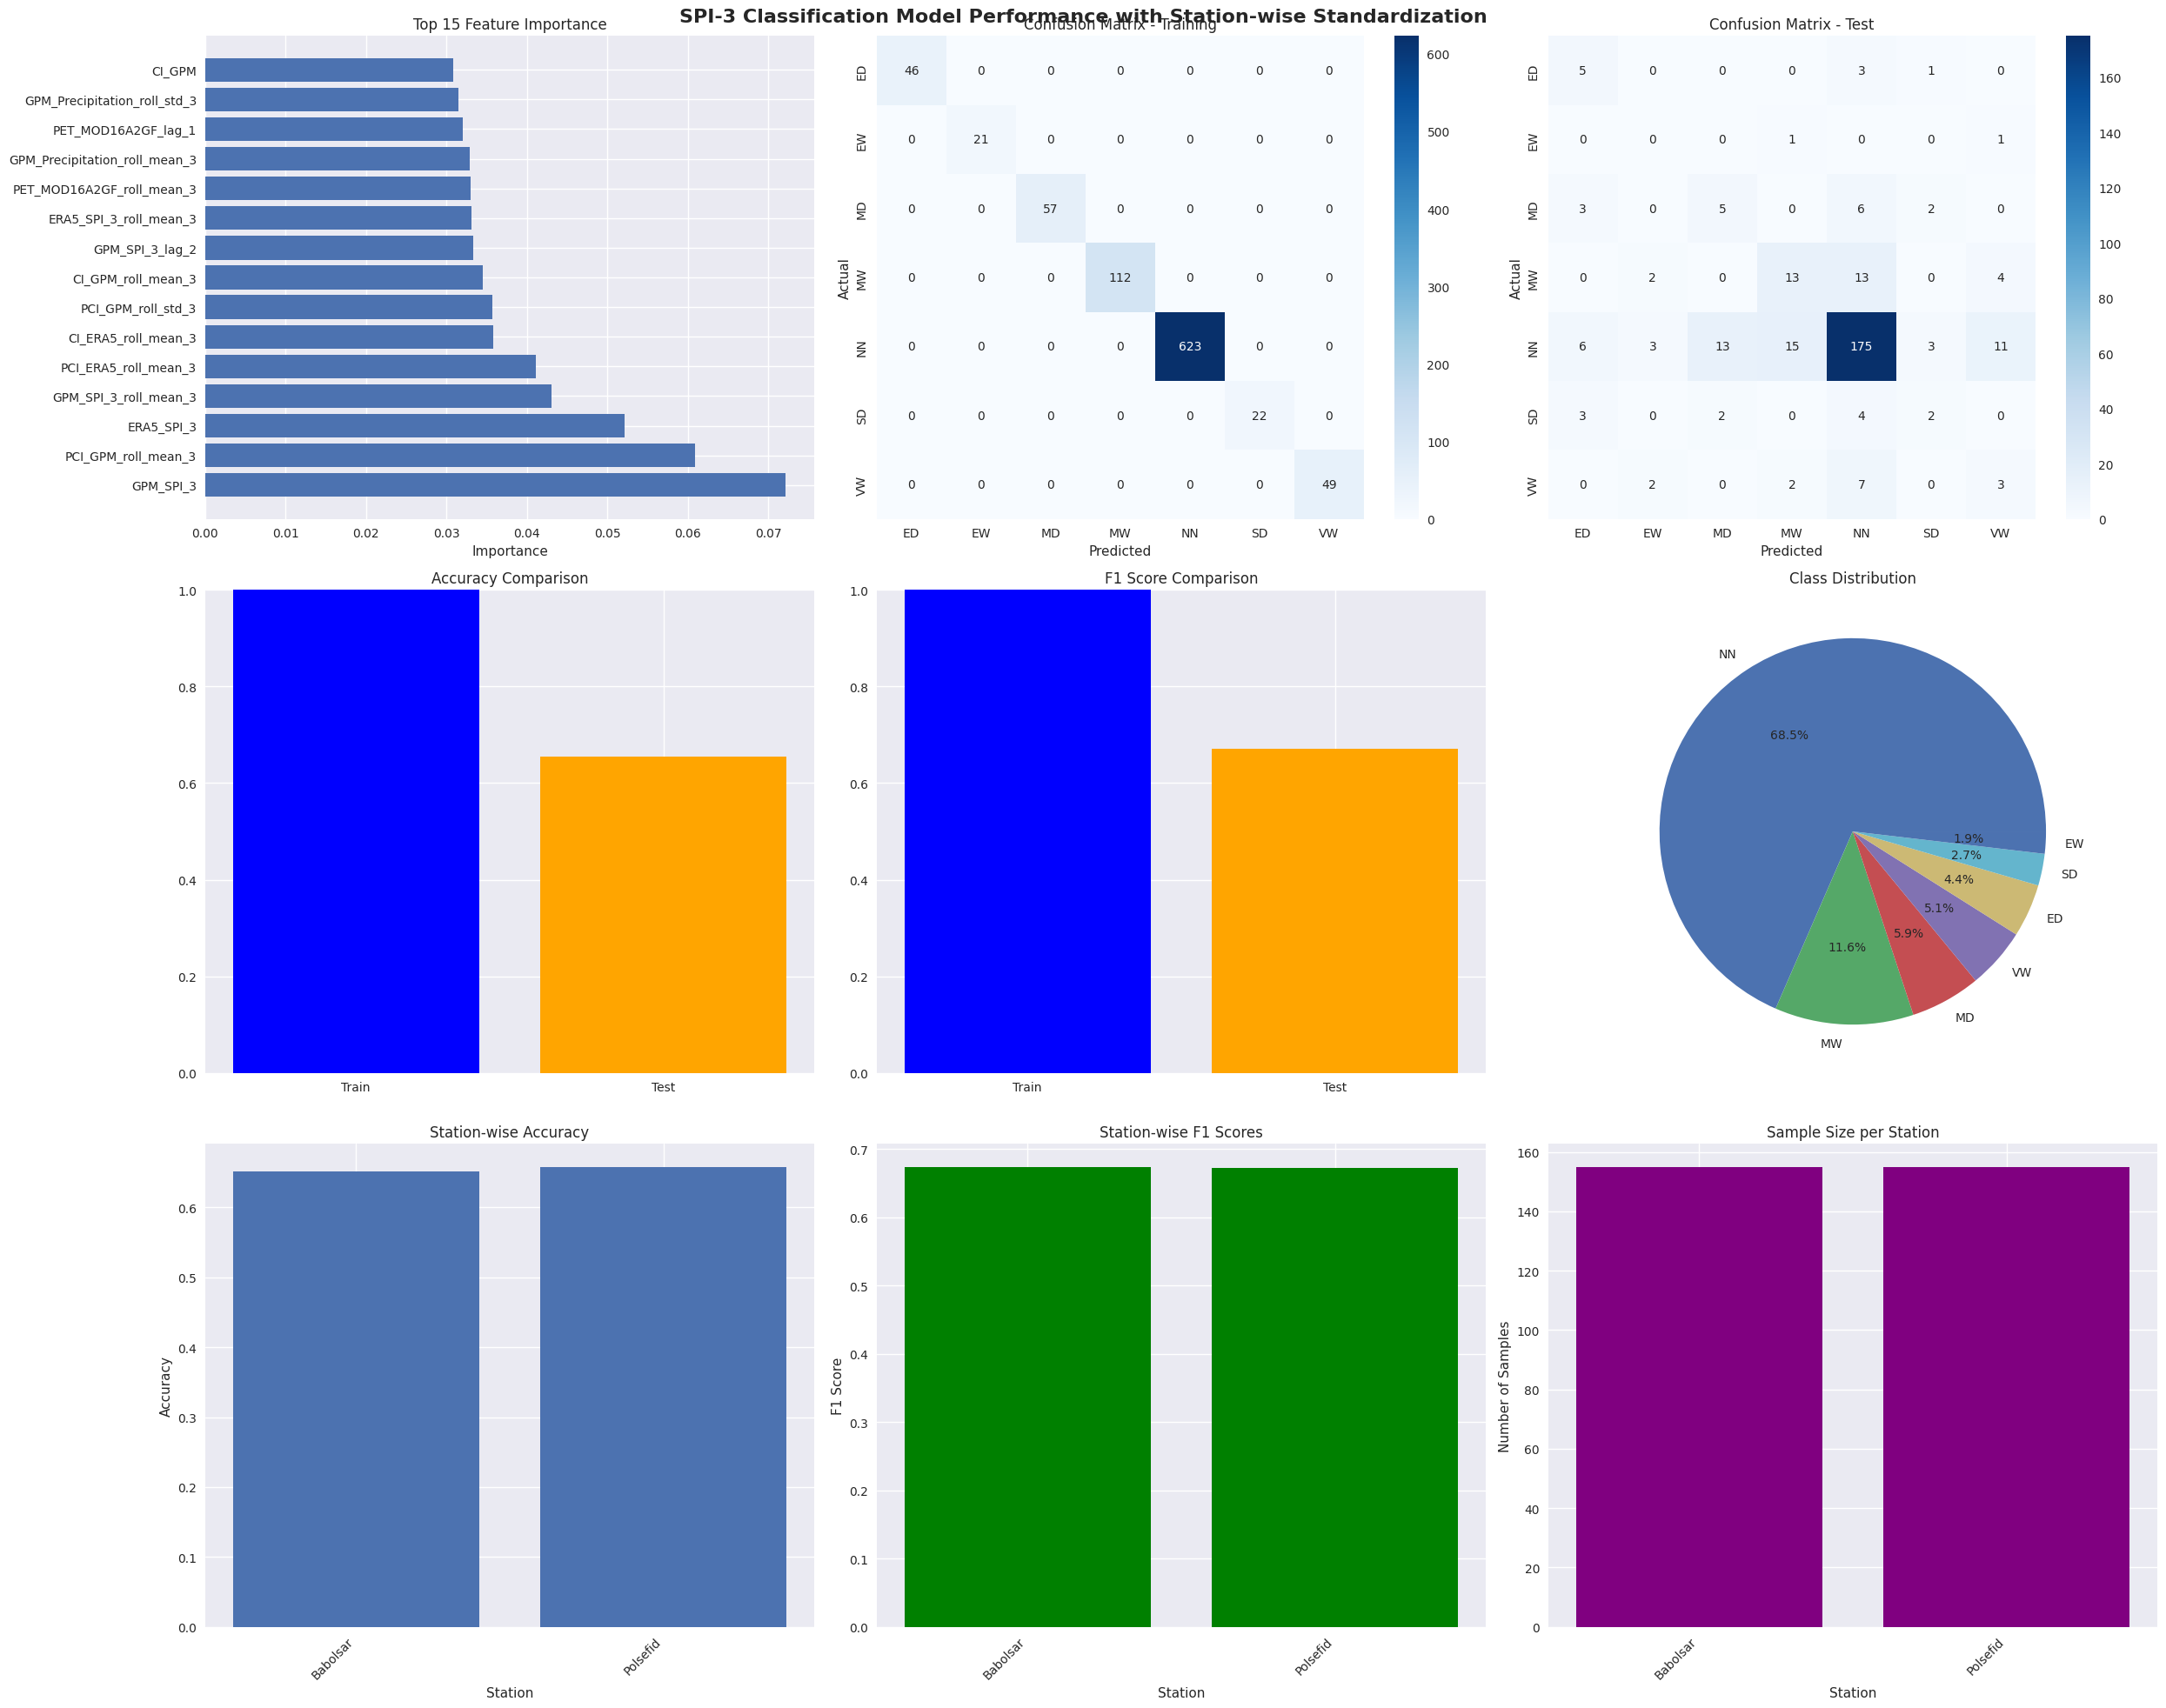


Model training and evaluation completed successfully!


In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GroupShuffleSplit
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectFromModel, mutual_info_classif
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

class SPI_GBM_Model:
    def __init__(self, df):
        self.df = df.copy()
        self.features = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.model = None
        self.best_params = None
        self.label_encoder = LabelEncoder()
        self.station_scalers = {}  # Store scalers for each station
        
    def station_wise_standardization(self):
        """Standardize features within each station separately"""
        print("Performing station-wise standardization...")
        
        # Identify numeric features to standardize (exclude categorical and target)
        exclude_cols = ['Station_Name', 'Station_ID', 'Date', 'SPI_3_Class', 
                       'Year', 'Month', 'SPI_3', 'SPI_3_Class_encoded']
        numeric_cols = [col for col in self.df.select_dtypes(include=[np.number]).columns 
                       if col not in exclude_cols]
        
        # Standardize within each station
        df_standardized = self.df.copy()
        
        for station in self.df['Station_Name'].unique():
            station_mask = self.df['Station_Name'] == station
            
            # Create and fit scaler for this station
            scaler = StandardScaler()
            station_data = self.df.loc[station_mask, numeric_cols]
            
            if len(station_data) > 0:
                scaled_data = scaler.fit_transform(station_data)
                df_standardized.loc[station_mask, numeric_cols] = scaled_data
                self.station_scalers[station] = scaler
        
        return df_standardized
    
    def preprocess_data(self):
        """Preprocess the data with station-wise standardization"""
        print("Preprocessing data with station-wise standardization...")
        
        # Drop columns with too many missing values
        missing_threshold = 0.3
        missing_ratios = self.df.isnull().mean()
        cols_to_drop = missing_ratios[missing_ratios > missing_threshold].index.tolist()
        self.df = self.df.drop(columns=cols_to_drop)
        
        # Fill remaining missing values with station-specific means
        for col in self.df.select_dtypes(include=[np.number]).columns:
            if col not in ['Station_Name', 'Station_ID']:
                self.df[col] = self.df.groupby('Station_Name')[col].transform(
                    lambda x: x.fillna(x.mean()))
        
        # Encode target variable
        self.df['SPI_3_Class_encoded'] = self.label_encoder.fit_transform(self.df['SPI_3_Class'])
        
        # Apply station-wise standardization
        self.df = self.station_wise_standardization()
        
        return self.df
    
    def select_features(self, method='mutual_info', top_k=30):
        """Select the most important features using multiple methods"""
        print(f"Selecting features using {method} method...")
        
        # Define features to exclude
        exclude_cols = ['Station_Name', 'Station_ID', 'Date', 'SPI_3_Class', 
                       'SPI_3_Class_encoded', 'Year', 'Month', 'SPI_3']
        
        # Get all numeric columns except excluded ones
        all_features = [col for col in self.df.select_dtypes(include=[np.number]).columns 
                       if col not in exclude_cols]
        
        X = self.df[all_features]
        y = self.df['SPI_3_Class_encoded']
        
        if method == 'mutual_info':
            # Mutual information feature selection
            mi_scores = mutual_info_classif(X, y, random_state=42)
            mi_df = pd.DataFrame({'feature': all_features, 'mi_score': mi_scores})
            mi_df = mi_df.sort_values('mi_score', ascending=False)
            selected_features = mi_df.head(top_k)['feature'].tolist()
            
        elif method == 'gbm_importance':
            # Gradient Boosting feature importance
            gbm = GradientBoostingClassifier(n_estimators=100, random_state=42)
            gbm.fit(X, y)
            selector = SelectFromModel(gbm, prefit=True, threshold='median')
            selected_features = X.columns[selector.get_support()].tolist()
            
        elif method == 'correlation':
            # Correlation with target
            corr_scores = []
            for feature in all_features:
                if len(self.df[feature].unique()) > 1:  # Avoid constant features
                    corr = np.corrcoef(self.df[feature], y)[0, 1]
                    corr_scores.append(abs(corr))
                else:
                    corr_scores.append(0)
            
            corr_df = pd.DataFrame({'feature': all_features, 'corr_score': corr_scores})
            corr_df = corr_df.sort_values('corr_score', ascending=False)
            selected_features = corr_df.head(top_k)['feature'].tolist()
        
        print(f"Selected {len(selected_features)} features out of {len(all_features)}")
        self.features = selected_features
        
        return selected_features
    
    def prepare_train_test(self, test_size=0.2, group_by_station=True):
        """Prepare train-test split, optionally keeping stations together"""
        print("Preparing train-test split...")
        
        X = self.df[self.features]
        y = self.df['SPI_3_Class_encoded']
        
        if group_by_station:
            # Use GroupShuffleSplit to keep stations together
            groups = self.df['Station_Name']
            gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
            
            for train_idx, test_idx in gss.split(X, y, groups):
                self.X_train, self.X_test = X.iloc[train_idx], X.iloc[test_idx]
                self.y_train, self.y_test = y.iloc[train_idx], y.iloc[test_idx]
                self.train_stations = groups.iloc[train_idx].unique()
                self.test_stations = groups.iloc[test_idx].unique()
        else:
            # Regular random split
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
                X, y, test_size=test_size, random_state=42, stratify=y
            )
        
        print(f"Training stations: {len(self.train_stations) if group_by_station else 'N/A'}")
        print(f"Test stations: {len(self.test_stations) if group_by_station else 'N/A'}")
        
        return self.X_train, self.X_test, self.y_train, self.y_test
    
    def get_hyperparameter_space(self):
        """Define hyperparameter search space for Gradient Boosting"""
        param_dist = {
            'gbm__n_estimators': [100, 200, 300, 500],
            'gbm__learning_rate': [0.01, 0.05, 0.1, 0.2],
            'gbm__max_depth': [3, 5, 7, 9],
            'gbm__min_samples_split': [2, 5, 10],
            'gbm__min_samples_leaf': [1, 2, 4],
            'gbm__subsample': [0.8, 0.9, 1.0],
            'gbm__max_features': ['sqrt', 'log2', None],
            'gbm__random_state': [42]
        }
        return param_dist
    
    def train_model(self, n_iter=50, cv=3):
        """Train the model with hyperparameter tuning and SMOTE"""
        print("Training model with hyperparameter tuning...")
        
        # Create pipeline with SMOTE and Gradient Boosting
        pipeline = ImbPipeline([
            ('smote', SMOTE(random_state=42)),
            ('gbm', GradientBoostingClassifier(random_state=42))
        ])
        
        # Hyperparameter tuning
        param_dist = self.get_hyperparameter_space()
        random_search = RandomizedSearchCV(
            pipeline, param_dist, n_iter=n_iter, cv=cv, 
            scoring='f1_weighted', random_state=42, n_jobs=-1, verbose=1
        )
        
        random_search.fit(self.X_train, self.y_train)
        
        self.model = random_search.best_estimator_
        self.best_params = random_search.best_params_
        
        print("Best parameters found:", self.best_params)
        return self.model
    
    def evaluate_model(self):
        """Comprehensive model evaluation with station-wise analysis"""
        print("Evaluating model...")
        
        # Predictions
        y_pred_train = self.model.predict(self.X_train)
        y_pred_test = self.model.predict(self.X_test)
        
        # Convert back to original labels
        y_train_orig = self.label_encoder.inverse_transform(self.y_train)
        y_test_orig = self.label_encoder.inverse_transform(self.y_test)
        y_pred_train_orig = self.label_encoder.inverse_transform(y_pred_train)
        y_pred_test_orig = self.label_encoder.inverse_transform(y_pred_test)
        
        # Calculate overall metrics
        train_accuracy = accuracy_score(y_train_orig, y_pred_train_orig)
        test_accuracy = accuracy_score(y_test_orig, y_pred_test_orig)
        train_f1 = f1_score(y_train_orig, y_pred_train_orig, average='weighted')
        test_f1 = f1_score(y_test_orig, y_pred_test_orig, average='weighted')
        
        # Station-wise performance
        station_performance = self._calculate_station_performance()
        
        # Classification reports
        train_report = classification_report(y_train_orig, y_pred_train_orig)
        test_report = classification_report(y_test_orig, y_pred_test_orig)
        
        # Confusion matrices
        train_cm = confusion_matrix(y_train_orig, y_pred_train_orig)
        test_cm = confusion_matrix(y_test_orig, y_pred_test_orig)
        
        results = {
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy,
            'train_f1': train_f1,
            'test_f1': test_f1,
            'train_report': train_report,
            'test_report': test_report,
            'train_cm': train_cm,
            'test_cm': test_cm,
            'feature_importance': self.get_feature_importance(),
            'class_names': self.label_encoder.classes_,
            'station_performance': station_performance,
            'train_stations': self.train_stations if hasattr(self, 'train_stations') else None,
            'test_stations': self.test_stations if hasattr(self, 'test_stations') else None
        }
        
        return results
    
    def _calculate_station_performance(self):
        """Calculate performance metrics for each station"""
        station_performance = {}
        
        # Add station information to test data
        test_df = self.X_test.copy()
        test_df['true_class'] = self.y_test.values
        test_df['pred_class'] = self.model.predict(self.X_test)
        test_df['station'] = self.df.iloc[self.X_test.index]['Station_Name'].values
        
        for station in test_df['station'].unique():
            station_data = test_df[test_df['station'] == station]
            if len(station_data) > 0:
                accuracy = accuracy_score(station_data['true_class'], station_data['pred_class'])
                f1 = f1_score(station_data['true_class'], station_data['pred_class'], 
                             average='weighted')
                station_performance[station] = {
                    'accuracy': accuracy,
                    'f1_score': f1,
                    'n_samples': len(station_data)
                }
        
        return station_performance
    
    def get_feature_importance(self):
        """Get feature importance from the trained model"""
        gbm_model = self.model.named_steps['gbm']
        importance_df = pd.DataFrame({
            'feature': self.features,
            'importance': gbm_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        return importance_df
    
    def generate_summary(self, results):
        """Generate comprehensive summary with station-wise analysis"""
        print("\n" + "="*60)
        print("COMPREHENSIVE MODEL SUMMARY")
        print("="*60)
        
        print(f"\nBest Parameters: {self.best_params}")
        print(f"\nOverall Performance:")
        print(f"Train Accuracy: {results['train_accuracy']:.4f}")
        print(f"Test Accuracy: {results['test_accuracy']:.4f}")
        print(f"Train F1 Score: {results['train_f1']:.4f}")
        print(f"Test F1 Score: {results['test_f1']:.4f}")
        
        print(f"\nTraining Stations: {len(results['train_stations']) if results['train_stations'] is not None else 'N/A'}")
        print(f"Test Stations: {len(results['test_stations']) if results['test_stations'] is not None else 'N/A'}")
        
        print("\nTop 10 Most Important Features:")
        print(results['feature_importance'].head(10).to_string(index=False))
        
        print("\nStation-wise Performance:")
        for station, metrics in results['station_performance'].items():
            print(f"{station}: Accuracy={metrics['accuracy']:.3f}, F1={metrics['f1_score']:.3f}, Samples={metrics['n_samples']}")
        
        print("\nTraining Classification Report:")
        print(results['train_report'])
        
        print("\nTest Classification Report:")
        print(results['test_report'])
    
    def create_visualizations(self, results):
        """Create comprehensive visualizations including station-wise analysis"""
        print("Creating visualizations...")
        
        # Set style
        plt.style.use('seaborn-v0_8')
        fig, axes = plt.subplots(3, 3, figsize=(25, 20))
        fig.suptitle('SPI-3 Classification Model Performance with Station-wise Standardization', 
                    fontsize=16, fontweight='bold')
        
        # 1. Feature Importance Plot
        top_features = results['feature_importance'].head(15)
        axes[0, 0].barh(range(len(top_features)), top_features['importance'])
        axes[0, 0].set_yticks(range(len(top_features)))
        axes[0, 0].set_yticklabels(top_features['feature'])
        axes[0, 0].set_title('Top 15 Feature Importance')
        axes[0, 0].set_xlabel('Importance')
        
        # 2. Confusion Matrix - Train
        sns.heatmap(results['train_cm'], annot=True, fmt='d', cmap='Blues',
                   xticklabels=results['class_names'],
                   yticklabels=results['class_names'], ax=axes[0, 1])
        axes[0, 1].set_title('Confusion Matrix - Training')
        axes[0, 1].set_xlabel('Predicted')
        axes[0, 1].set_ylabel('Actual')
        
        # 3. Confusion Matrix - Test
        sns.heatmap(results['test_cm'], annot=True, fmt='d', cmap='Blues',
                   xticklabels=results['class_names'],
                   yticklabels=results['class_names'], ax=axes[0, 2])
        axes[0, 2].set_title('Confusion Matrix - Test')
        axes[0, 2].set_xlabel('Predicted')
        axes[0, 2].set_ylabel('Actual')
        
        # 4. Accuracy Comparison
        acc_data = pd.DataFrame({
            'Dataset': ['Train', 'Test'],
            'Accuracy': [results['train_accuracy'], results['test_accuracy']]
        })
        axes[1, 0].bar(acc_data['Dataset'], acc_data['Accuracy'], color=['blue', 'orange'])
        axes[1, 0].set_title('Accuracy Comparison')
        axes[1, 0].set_ylim(0, 1)
        
        # 5. F1 Score Comparison
        f1_data = pd.DataFrame({
            'Dataset': ['Train', 'Test'],
            'F1_Score': [results['train_f1'], results['test_f1']]
        })
        axes[1, 1].bar(f1_data['Dataset'], f1_data['F1_Score'], color=['blue', 'orange'])
        axes[1, 1].set_title('F1 Score Comparison')
        axes[1, 1].set_ylim(0, 1)
        
        # 6. Class Distribution
        class_counts = pd.Series(self.label_encoder.inverse_transform(
            np.concatenate([self.y_train, self.y_test]))).value_counts()
        axes[1, 2].pie(class_counts, labels=class_counts.index, autopct='%1.1f%%')
        axes[1, 2].set_title('Class Distribution')
        
        # 7. Station-wise Performance
        if results['station_performance']:
            station_acc = [metrics['accuracy'] for metrics in results['station_performance'].values()]
            station_names = list(results['station_performance'].keys())
            axes[2, 0].bar(range(len(station_acc)), station_acc)
            axes[2, 0].set_title('Station-wise Accuracy')
            axes[2, 0].set_xlabel('Station')
            axes[2, 0].set_ylabel('Accuracy')
            axes[2, 0].set_xticks(range(len(station_names)))
            axes[2, 0].set_xticklabels(station_names, rotation=45, ha='right')
        
        # 8. Station F1 Scores
        if results['station_performance']:
            station_f1 = [metrics['f1_score'] for metrics in results['station_performance'].values()]
            axes[2, 1].bar(range(len(station_f1)), station_f1, color='green')
            axes[2, 1].set_title('Station-wise F1 Scores')
            axes[2, 1].set_xlabel('Station')
            axes[2, 1].set_ylabel('F1 Score')
            axes[2, 1].set_xticks(range(len(station_names)))
            axes[2, 1].set_xticklabels(station_names, rotation=45, ha='right')
        
        # 9. Sample Size per Station
        if results['station_performance']:
            station_samples = [metrics['n_samples'] for metrics in results['station_performance'].values()]
            axes[2, 2].bar(range(len(station_samples)), station_samples, color='purple')
            axes[2, 2].set_title('Sample Size per Station')
            axes[2, 2].set_xlabel('Station')
            axes[2, 2].set_ylabel('Number of Samples')
            axes[2, 2].set_xticks(range(len(station_names)))
            axes[2, 2].set_xticklabels(station_names, rotation=45, ha='right')
        
        plt.tight_layout()
        plt.savefig('spi_gbm_station_standardized_performance.png', dpi=300, bbox_inches='tight')
        plt.show()

# Main execution function
def main():
    # Load your data
    # df = pd.read_csv('your_data.csv')  # Replace with your actual data loading
    
    # Initialize and run the model
    model = SPI_GBM_Model(df)
    
    # Preprocess data with station-wise standardization
    df_processed = model.preprocess_data()
    
    # Select features using multiple methods
    selected_features = model.select_features(method='mutual_info', top_k=30)
    print(f"Selected features: {selected_features}")
    
    # Prepare train-test split keeping stations together
    X_train, X_test, y_train, y_test = model.prepare_train_test(group_by_station=True)
    
    # Train model
    trained_model = model.train_model(n_iter=30, cv=3)
    
    # Evaluate model
    results = model.evaluate_model()
    
    # Generate summary
    model.generate_summary(results)
    
    # Create visualizations
    model.create_visualizations(results)
    
    print("\nModel training and evaluation completed successfully!")

if __name__ == "__main__":
    main()

Preprocessing data with station-wise standardization...
Performing station-wise standardization...
Selecting features using mutual_info method...
Selected 30 features out of 126
Selected features: ['GPM_SPI_3', 'PCI_GPM_roll_mean_3', 'GPM_SPI_3_roll_mean_3', 'ERA5_SPI_3', 'PCI_ERA5_roll_mean_3', 'CI_GPM_roll_mean_3', 'ERA5_SPI_3_roll_mean_3', 'TRMM_Precipitation_roll_mean_3', 'GPM_Precipitation_roll_mean_3', 'GPM_SPI_3_lag_1', 'PCI_GPM_lag_2', 'ERA5_Precipitation_roll_mean_3', 'PERSIANNCDR_Precipitation_roll_mean_3', 'CI_ERA5_roll_mean_3', 'GPM_Precipitation_lag_2', 'GPM_SPI_3_lag_2', 'PCI_GPM', 'PCI_ERA5_lag_2', 'GPM_Precipitation_roll_std_3', 'CI_GPM', 'CI_ERA5_lag_1', 'GPM_Precipitation_lag_1', 'ERA5_SPI_3_lag_1', 'TRMM_Precipitation', 'CI_GPM_lag_1', 'PET_MOD16A2GF_lag_1', 'TERRACLIMATE_Precipitation_lag_2', 'GPM_Precipitation', 'PET_MOD16A2GF_roll_mean_3', 'PCI_GPM_roll_std_3']
Preparing 80-20 train-test split on entire dataset...
Training samples: 992
Test samples: 248
Unique sta

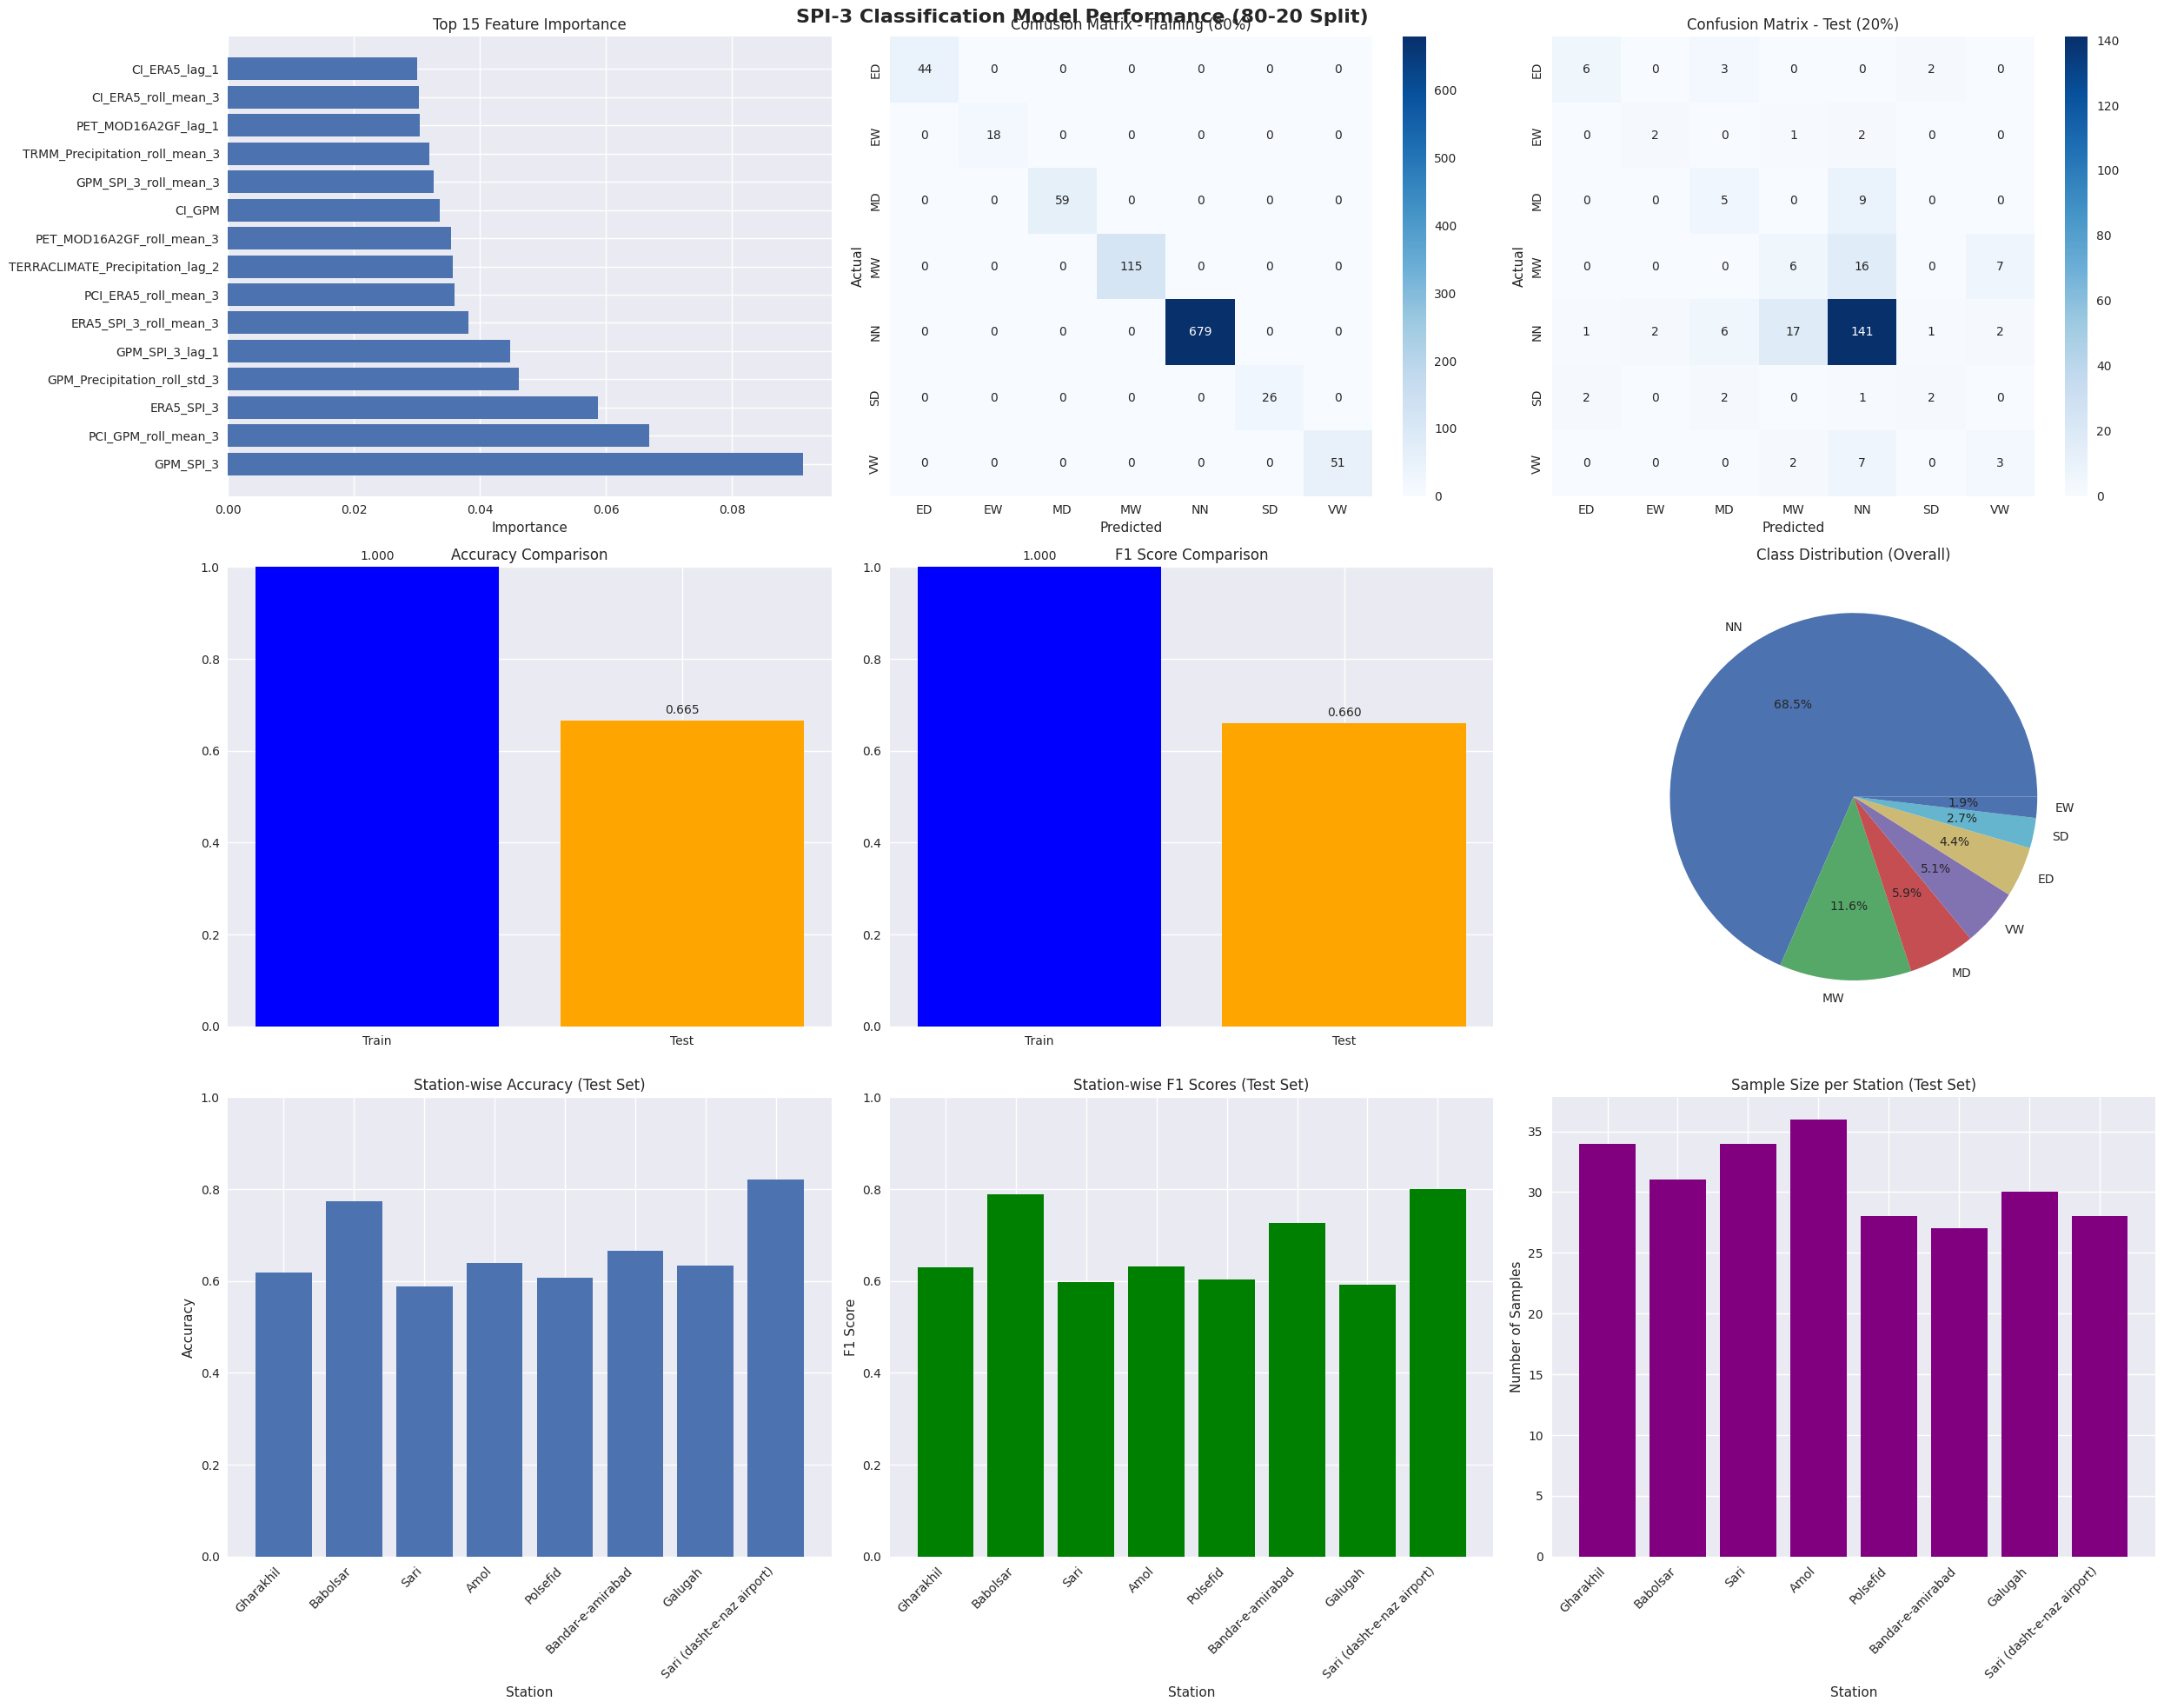

<Figure size 1200x800 with 0 Axes>

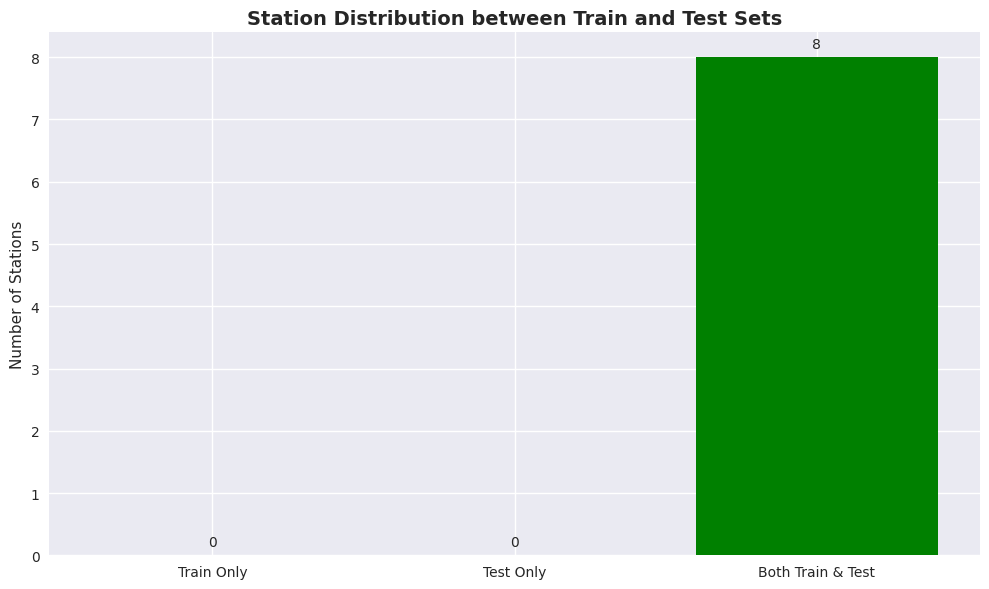


Model training and evaluation completed successfully!
Visualizations saved as:
- spi_gbm_80_20_split_performance.png
- station_distribution.png


In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectFromModel, mutual_info_classif
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

class SPI_GBM_Model:
    def __init__(self, df):
        self.df = df.copy()
        self.features = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.model = None
        self.best_params = None
        self.label_encoder = LabelEncoder()
        self.station_scalers = {}  # Store scalers for each station
        
    def station_wise_standardization(self):
        """Standardize features within each station separately"""
        print("Performing station-wise standardization...")
        
        # Identify numeric features to standardize (exclude categorical and target)
        exclude_cols = ['Station_Name', 'Station_ID', 'Date', 'SPI_3_Class', 
                       'Year', 'Month', 'SPI_3', 'SPI_3_Class_encoded']
        numeric_cols = [col for col in self.df.select_dtypes(include=[np.number]).columns 
                       if col not in exclude_cols]
        
        # Standardize within each station
        df_standardized = self.df.copy()
        
        for station in self.df['Station_Name'].unique():
            station_mask = self.df['Station_Name'] == station
            
            # Create and fit scaler for this station
            scaler = StandardScaler()
            station_data = self.df.loc[station_mask, numeric_cols]
            
            if len(station_data) > 0:
                scaled_data = scaler.fit_transform(station_data)
                df_standardized.loc[station_mask, numeric_cols] = scaled_data
                self.station_scalers[station] = scaler
        
        return df_standardized
    
    def preprocess_data(self):
        """Preprocess the data with station-wise standardization"""
        print("Preprocessing data with station-wise standardization...")
        
        # Drop columns with too many missing values
        missing_threshold = 0.3
        missing_ratios = self.df.isnull().mean()
        cols_to_drop = missing_ratios[missing_ratios > missing_threshold].index.tolist()
        self.df = self.df.drop(columns=cols_to_drop)
        
        # Fill remaining missing values with station-specific means
        for col in self.df.select_dtypes(include=[np.number]).columns:
            if col not in ['Station_Name', 'Station_ID']:
                self.df[col] = self.df.groupby('Station_Name')[col].transform(
                    lambda x: x.fillna(x.mean()))
        
        # Encode target variable
        self.df['SPI_3_Class_encoded'] = self.label_encoder.fit_transform(self.df['SPI_3_Class'])
        
        # Apply station-wise standardization
        self.df = self.station_wise_standardization()
        
        return self.df
    
    def select_features(self, method='gbm_importance', top_k=30):
        """Select the most important features using multiple methods"""
        print(f"Selecting features using {method} method...")
        
        # Define features to exclude
        exclude_cols = ['Station_Name', 'Station_ID', 'Date', 'SPI_3_Class', 
                       'SPI_3_Class_encoded', 'Year', 'Month', 'SPI_3']
        
        # Get all numeric columns except excluded ones
        all_features = [col for col in self.df.select_dtypes(include=[np.number]).columns 
                       if col not in exclude_cols]
        
        X = self.df[all_features]
        y = self.df['SPI_3_Class_encoded']
        
        if method == 'mutual_info':
            # Mutual information feature selection
            mi_scores = mutual_info_classif(X, y, random_state=42)
            mi_df = pd.DataFrame({'feature': all_features, 'mi_score': mi_scores})
            mi_df = mi_df.sort_values('mi_score', ascending=False)
            selected_features = mi_df.head(top_k)['feature'].tolist()
            
        elif method == 'gbm_importance':
            # Gradient Boosting feature importance
            gbm = GradientBoostingClassifier(n_estimators=100, random_state=42)
            gbm.fit(X, y)
            selector = SelectFromModel(gbm, prefit=True, threshold='median')
            selected_features = X.columns[selector.get_support()].tolist()
            
        elif method == 'correlation':
            # Correlation with target
            corr_scores = []
            for feature in all_features:
                if len(self.df[feature].unique()) > 1:  # Avoid constant features
                    corr = np.corrcoef(self.df[feature], y)[0, 1]
                    corr_scores.append(abs(corr))
                else:
                    corr_scores.append(0)
            
            corr_df = pd.DataFrame({'feature': all_features, 'corr_score': corr_scores})
            corr_df = corr_df.sort_values('corr_score', ascending=False)
            selected_features = corr_df.head(top_k)['feature'].tolist()
        
        print(f"Selected {len(selected_features)} features out of {len(all_features)}")
        self.features = selected_features
        
        return selected_features
    
    def prepare_train_test(self, test_size=0.2):
        """Prepare 80-20 train-test split on the entire dataset"""
        print("Preparing 80-20 train-test split on entire dataset...")
        
        X = self.df[self.features]
        y = self.df['SPI_3_Class_encoded']
        
        # Regular random 80-20 split
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=y
        )
        
        # Store station information for analysis
        self.train_stations = self.df.iloc[self.X_train.index]['Station_Name'].unique()
        self.test_stations = self.df.iloc[self.X_test.index]['Station_Name'].unique()
        
        print(f"Training samples: {len(self.X_train)}")
        print(f"Test samples: {len(self.X_test)}")
        print(f"Unique stations in training: {len(self.train_stations)}")
        print(f"Unique stations in test: {len(self.test_stations)}")
        print(f"Stations in both train and test: {len(set(self.train_stations) & set(self.test_stations))}")
        
        return self.X_train, self.X_test, self.y_train, self.y_test
    
    def get_hyperparameter_space(self):
        """Define hyperparameter search space for Gradient Boosting"""
        param_dist = {
            'gbm__n_estimators': [100, 200, 300, 500],
            'gbm__learning_rate': [0.01, 0.05, 0.1, 0.2],
            'gbm__max_depth': [3, 5, 7, 9],
            'gbm__min_samples_split': [2, 5, 10],
            'gbm__min_samples_leaf': [1, 2, 4],
            'gbm__subsample': [0.8, 0.9, 1.0],
            'gbm__max_features': ['sqrt', 'log2', None],
            'gbm__random_state': [42]
        }
        return param_dist
    
    def train_model(self, n_iter=50, cv=3):
        """Train the model with hyperparameter tuning and SMOTE"""
        print("Training model with hyperparameter tuning...")
        
        # Create pipeline with SMOTE and Gradient Boosting
        pipeline = ImbPipeline([
            ('smote', SMOTE(random_state=42)),
            ('gbm', GradientBoostingClassifier(random_state=42))
        ])
        
        # Hyperparameter tuning
        param_dist = self.get_hyperparameter_space()
        random_search = RandomizedSearchCV(
            pipeline, param_dist, n_iter=n_iter, cv=cv, 
            scoring='f1_weighted', random_state=42, n_jobs=-1, verbose=1
        )
        
        random_search.fit(self.X_train, self.y_train)
        
        self.model = random_search.best_estimator_
        self.best_params = random_search.best_params_
        
        print("Best parameters found:", self.best_params)
        return self.model
    
    def evaluate_model(self):
        """Comprehensive model evaluation with station-wise analysis"""
        print("Evaluating model...")
        
        # Predictions
        y_pred_train = self.model.predict(self.X_train)
        y_pred_test = self.model.predict(self.X_test)
        
        # Convert back to original labels
        y_train_orig = self.label_encoder.inverse_transform(self.y_train)
        y_test_orig = self.label_encoder.inverse_transform(self.y_test)
        y_pred_train_orig = self.label_encoder.inverse_transform(y_pred_train)
        y_pred_test_orig = self.label_encoder.inverse_transform(y_pred_test)
        
        # Calculate overall metrics
        train_accuracy = accuracy_score(y_train_orig, y_pred_train_orig)
        test_accuracy = accuracy_score(y_test_orig, y_pred_test_orig)
        train_f1 = f1_score(y_train_orig, y_pred_train_orig, average='weighted')
        test_f1 = f1_score(y_test_orig, y_pred_test_orig, average='weighted')
        
        # Station-wise performance
        station_performance = self._calculate_station_performance()
        
        # Classification reports
        train_report = classification_report(y_train_orig, y_pred_train_orig)
        test_report = classification_report(y_test_orig, y_pred_test_orig)
        
        # Confusion matrices
        train_cm = confusion_matrix(y_train_orig, y_pred_train_orig)
        test_cm = confusion_matrix(y_test_orig, y_pred_test_orig)
        
        results = {
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy,
            'train_f1': train_f1,
            'test_f1': test_f1,
            'train_report': train_report,
            'test_report': test_report,
            'train_cm': train_cm,
            'test_cm': test_cm,
            'feature_importance': self.get_feature_importance(),
            'class_names': self.label_encoder.classes_,
            'station_performance': station_performance,
            'train_stations': self.train_stations,
            'test_stations': self.test_stations
        }
        
        return results
    
    def _calculate_station_performance(self):
        """Calculate performance metrics for each station"""
        station_performance = {}
        
        # Add station information to test data
        test_df = self.X_test.copy()
        test_df['true_class'] = self.y_test.values
        test_df['pred_class'] = self.model.predict(self.X_test)
        test_df['station'] = self.df.iloc[self.X_test.index]['Station_Name'].values
        
        for station in test_df['station'].unique():
            station_data = test_df[test_df['station'] == station]
            if len(station_data) > 0:
                accuracy = accuracy_score(station_data['true_class'], station_data['pred_class'])
                f1 = f1_score(station_data['true_class'], station_data['pred_class'], 
                             average='weighted')
                station_performance[station] = {
                    'accuracy': accuracy,
                    'f1_score': f1,
                    'n_samples': len(station_data)
                }
        
        return station_performance
    
    def get_feature_importance(self):
        """Get feature importance from the trained model"""
        gbm_model = self.model.named_steps['gbm']
        importance_df = pd.DataFrame({
            'feature': self.features,
            'importance': gbm_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        return importance_df
    
    def generate_summary(self, results):
        """Generate comprehensive summary with station-wise analysis"""
        print("\n" + "="*60)
        print("COMPREHENSIVE MODEL SUMMARY")
        print("="*60)
        
        print(f"\nBest Parameters: {self.best_params}")
        print(f"\nOverall Performance:")
        print(f"Train Accuracy: {results['train_accuracy']:.4f}")
        print(f"Test Accuracy: {results['test_accuracy']:.4f}")
        print(f"Train F1 Score: {results['train_f1']:.4f}")
        print(f"Test F1 Score: {results['test_f1']:.4f}")
        
        print(f"\nTraining Samples: {len(self.X_train)}")
        print(f"Test Samples: {len(self.X_test)}")
        print(f"Unique stations in training: {len(results['train_stations'])}")
        print(f"Unique stations in test: {len(results['test_stations'])}")
        
        print("\nTop 10 Most Important Features:")
        print(results['feature_importance'].head(10).to_string(index=False))
        
        print("\nStation-wise Performance (Test Set):")
        for station, metrics in results['station_performance'].items():
            print(f"{station}: Accuracy={metrics['accuracy']:.3f}, F1={metrics['f1_score']:.3f}, Samples={metrics['n_samples']}")
        
        print("\nTraining Classification Report:")
        print(results['train_report'])
        
        print("\nTest Classification Report:")
        print(results['test_report'])
    
    def create_visualizations(self, results):
        """Create comprehensive visualizations including station-wise analysis"""
        print("Creating visualizations...")
        
        # Set style
        plt.style.use('seaborn-v0_8')
        fig, axes = plt.subplots(3, 3, figsize=(25, 20))
        fig.suptitle('SPI-3 Classification Model Performance (80-20 Split)', 
                    fontsize=16, fontweight='bold')
        
        # 1. Feature Importance Plot
        top_features = results['feature_importance'].head(15)
        axes[0, 0].barh(range(len(top_features)), top_features['importance'])
        axes[0, 0].set_yticks(range(len(top_features)))
        axes[0, 0].set_yticklabels(top_features['feature'])
        axes[0, 0].set_title('Top 15 Feature Importance')
        axes[0, 0].set_xlabel('Importance')
        
        # 2. Confusion Matrix - Train
        sns.heatmap(results['train_cm'], annot=True, fmt='d', cmap='Blues',
                   xticklabels=results['class_names'],
                   yticklabels=results['class_names'], ax=axes[0, 1])
        axes[0, 1].set_title('Confusion Matrix - Training (80%)')
        axes[0, 1].set_xlabel('Predicted')
        axes[0, 1].set_ylabel('Actual')
        
        # 3. Confusion Matrix - Test
        sns.heatmap(results['test_cm'], annot=True, fmt='d', cmap='Blues',
                   xticklabels=results['class_names'],
                   yticklabels=results['class_names'], ax=axes[0, 2])
        axes[0, 2].set_title('Confusion Matrix - Test (20%)')
        axes[0, 2].set_xlabel('Predicted')
        axes[0, 2].set_ylabel('Actual')
        
        # 4. Accuracy Comparison
        acc_data = pd.DataFrame({
            'Dataset': ['Train', 'Test'],
            'Accuracy': [results['train_accuracy'], results['test_accuracy']]
        })
        axes[1, 0].bar(acc_data['Dataset'], acc_data['Accuracy'], color=['blue', 'orange'])
        axes[1, 0].set_title('Accuracy Comparison')
        axes[1, 0].set_ylim(0, 1)
        for i, v in enumerate(acc_data['Accuracy']):
            axes[1, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
        
        # 5. F1 Score Comparison
        f1_data = pd.DataFrame({
            'Dataset': ['Train', 'Test'],
            'F1_Score': [results['train_f1'], results['test_f1']]
        })
        axes[1, 1].bar(f1_data['Dataset'], f1_data['F1_Score'], color=['blue', 'orange'])
        axes[1, 1].set_title('F1 Score Comparison')
        axes[1, 1].set_ylim(0, 1)
        for i, v in enumerate(f1_data['F1_Score']):
            axes[1, 1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
        
        # 6. Class Distribution
        class_counts = pd.Series(self.label_encoder.inverse_transform(
            np.concatenate([self.y_train, self.y_test]))).value_counts()
        axes[1, 2].pie(class_counts, labels=class_counts.index, autopct='%1.1f%%')
        axes[1, 2].set_title('Class Distribution (Overall)')
        
        # 7. Station-wise Accuracy
        if results['station_performance']:
            station_acc = [metrics['accuracy'] for metrics in results['station_performance'].values()]
            station_names = list(results['station_performance'].keys())
            axes[2, 0].bar(range(len(station_acc)), station_acc)
            axes[2, 0].set_title('Station-wise Accuracy (Test Set)')
            axes[2, 0].set_xlabel('Station')
            axes[2, 0].set_ylabel('Accuracy')
            axes[2, 0].set_ylim(0, 1)
            axes[2, 0].set_xticks(range(len(station_names)))
            axes[2, 0].set_xticklabels(station_names, rotation=45, ha='right')
        
        # 8. Station F1 Scores
        if results['station_performance']:
            station_f1 = [metrics['f1_score'] for metrics in results['station_performance'].values()]
            axes[2, 1].bar(range(len(station_f1)), station_f1, color='green')
            axes[2, 1].set_title('Station-wise F1 Scores (Test Set)')
            axes[2, 1].set_xlabel('Station')
            axes[2, 1].set_ylabel('F1 Score')
            axes[2, 1].set_ylim(0, 1)
            axes[2, 1].set_xticks(range(len(station_names)))
            axes[2, 1].set_xticklabels(station_names, rotation=45, ha='right')
        
        # 9. Sample Size per Station in Test Set
        if results['station_performance']:
            station_samples = [metrics['n_samples'] for metrics in results['station_performance'].values()]
            axes[2, 2].bar(range(len(station_samples)), station_samples, color='purple')
            axes[2, 2].set_title('Sample Size per Station (Test Set)')
            axes[2, 2].set_xlabel('Station')
            axes[2, 2].set_ylabel('Number of Samples')
            axes[2, 2].set_xticks(range(len(station_names)))
            axes[2, 2].set_xticklabels(station_names, rotation=45, ha='right')
        
        plt.tight_layout()
        plt.savefig('spi_gbm_80_20_split_performance.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Additional: Create training vs test station overlap visualization
        self._create_station_overlap_visualization(results)

    def _create_station_overlap_visualization(self, results):
        """Create visualization showing station overlap between train and test sets"""
        plt.figure(figsize=(12, 8))
        
        train_stations = set(results['train_stations'])
        test_stations = set(results['test_stations'])
        all_stations = train_stations | test_stations
        
        # Create Venn diagram-like visualization
        plt.figure(figsize=(10, 6))
        plt.title('Station Distribution between Train and Test Sets', fontsize=14, fontweight='bold')
        
        # Simple bar chart showing station counts
        categories = ['Train Only', 'Test Only', 'Both Train & Test']
        counts = [
            len(train_stations - test_stations),
            len(test_stations - train_stations),
            len(train_stations & test_stations)
        ]
        
        bars = plt.bar(categories, counts, color=['blue', 'orange', 'green'])
        plt.ylabel('Number of Stations')
        
        # Add value labels on bars
        for bar, count in zip(bars, counts):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                    str(count), ha='center', va='bottom')
        
        plt.tight_layout()
        plt.savefig('station_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()

# Main execution function
def main():
    # Load your data
    # df = pd.read_csv('your_data.csv')  # Replace with your actual data loading
    
    # Initialize and run the model
    model = SPI_GBM_Model(df)
    
    # Preprocess data with station-wise standardization
    df_processed = model.preprocess_data()
    
    # Select features using multiple methods
    selected_features = model.select_features(method='mutual_info', top_k=30)
    print(f"Selected features: {selected_features}")
    
    # Prepare 80-20 train-test split
    X_train, X_test, y_train, y_test = model.prepare_train_test(test_size=0.2)
    
    # Train model
    trained_model = model.train_model(n_iter=30, cv=3)
    
    # Evaluate model
    results = model.evaluate_model()
    
    # Generate summary
    model.generate_summary(results)
    
    # Create visualizations
    model.create_visualizations(results)
    
    print("\nModel training and evaluation completed successfully!")
    print("Visualizations saved as:")
    print("- spi_gbm_80_20_split_performance.png")
    print("- station_distribution.png")

if __name__ == "__main__":
    main()

Preprocessing data with station-wise standardization...
Performing station-wise standardization...
Selecting features using mutual_info method...
Selected 30 features out of 126
Selected features: ['GPM_SPI_3', 'PCI_GPM_roll_mean_3', 'GPM_SPI_3_roll_mean_3', 'ERA5_SPI_3', 'PCI_ERA5_roll_mean_3', 'CI_GPM_roll_mean_3', 'ERA5_SPI_3_roll_mean_3', 'TRMM_Precipitation_roll_mean_3', 'GPM_Precipitation_roll_mean_3', 'GPM_SPI_3_lag_1', 'PCI_GPM_lag_2', 'ERA5_Precipitation_roll_mean_3', 'PERSIANNCDR_Precipitation_roll_mean_3', 'CI_ERA5_roll_mean_3', 'GPM_Precipitation_lag_2', 'GPM_SPI_3_lag_2', 'PCI_GPM', 'PCI_ERA5_lag_2', 'GPM_Precipitation_roll_std_3', 'CI_GPM', 'CI_ERA5_lag_1', 'GPM_Precipitation_lag_1', 'ERA5_SPI_3_lag_1', 'TRMM_Precipitation', 'CI_GPM_lag_1', 'PET_MOD16A2GF_lag_1', 'TERRACLIMATE_Precipitation_lag_2', 'GPM_Precipitation', 'PET_MOD16A2GF_roll_mean_3', 'PCI_GPM_roll_std_3']
Preparing 80-20 train-test split on entire dataset...
Training samples: 992
Test samples: 248
Unique sta

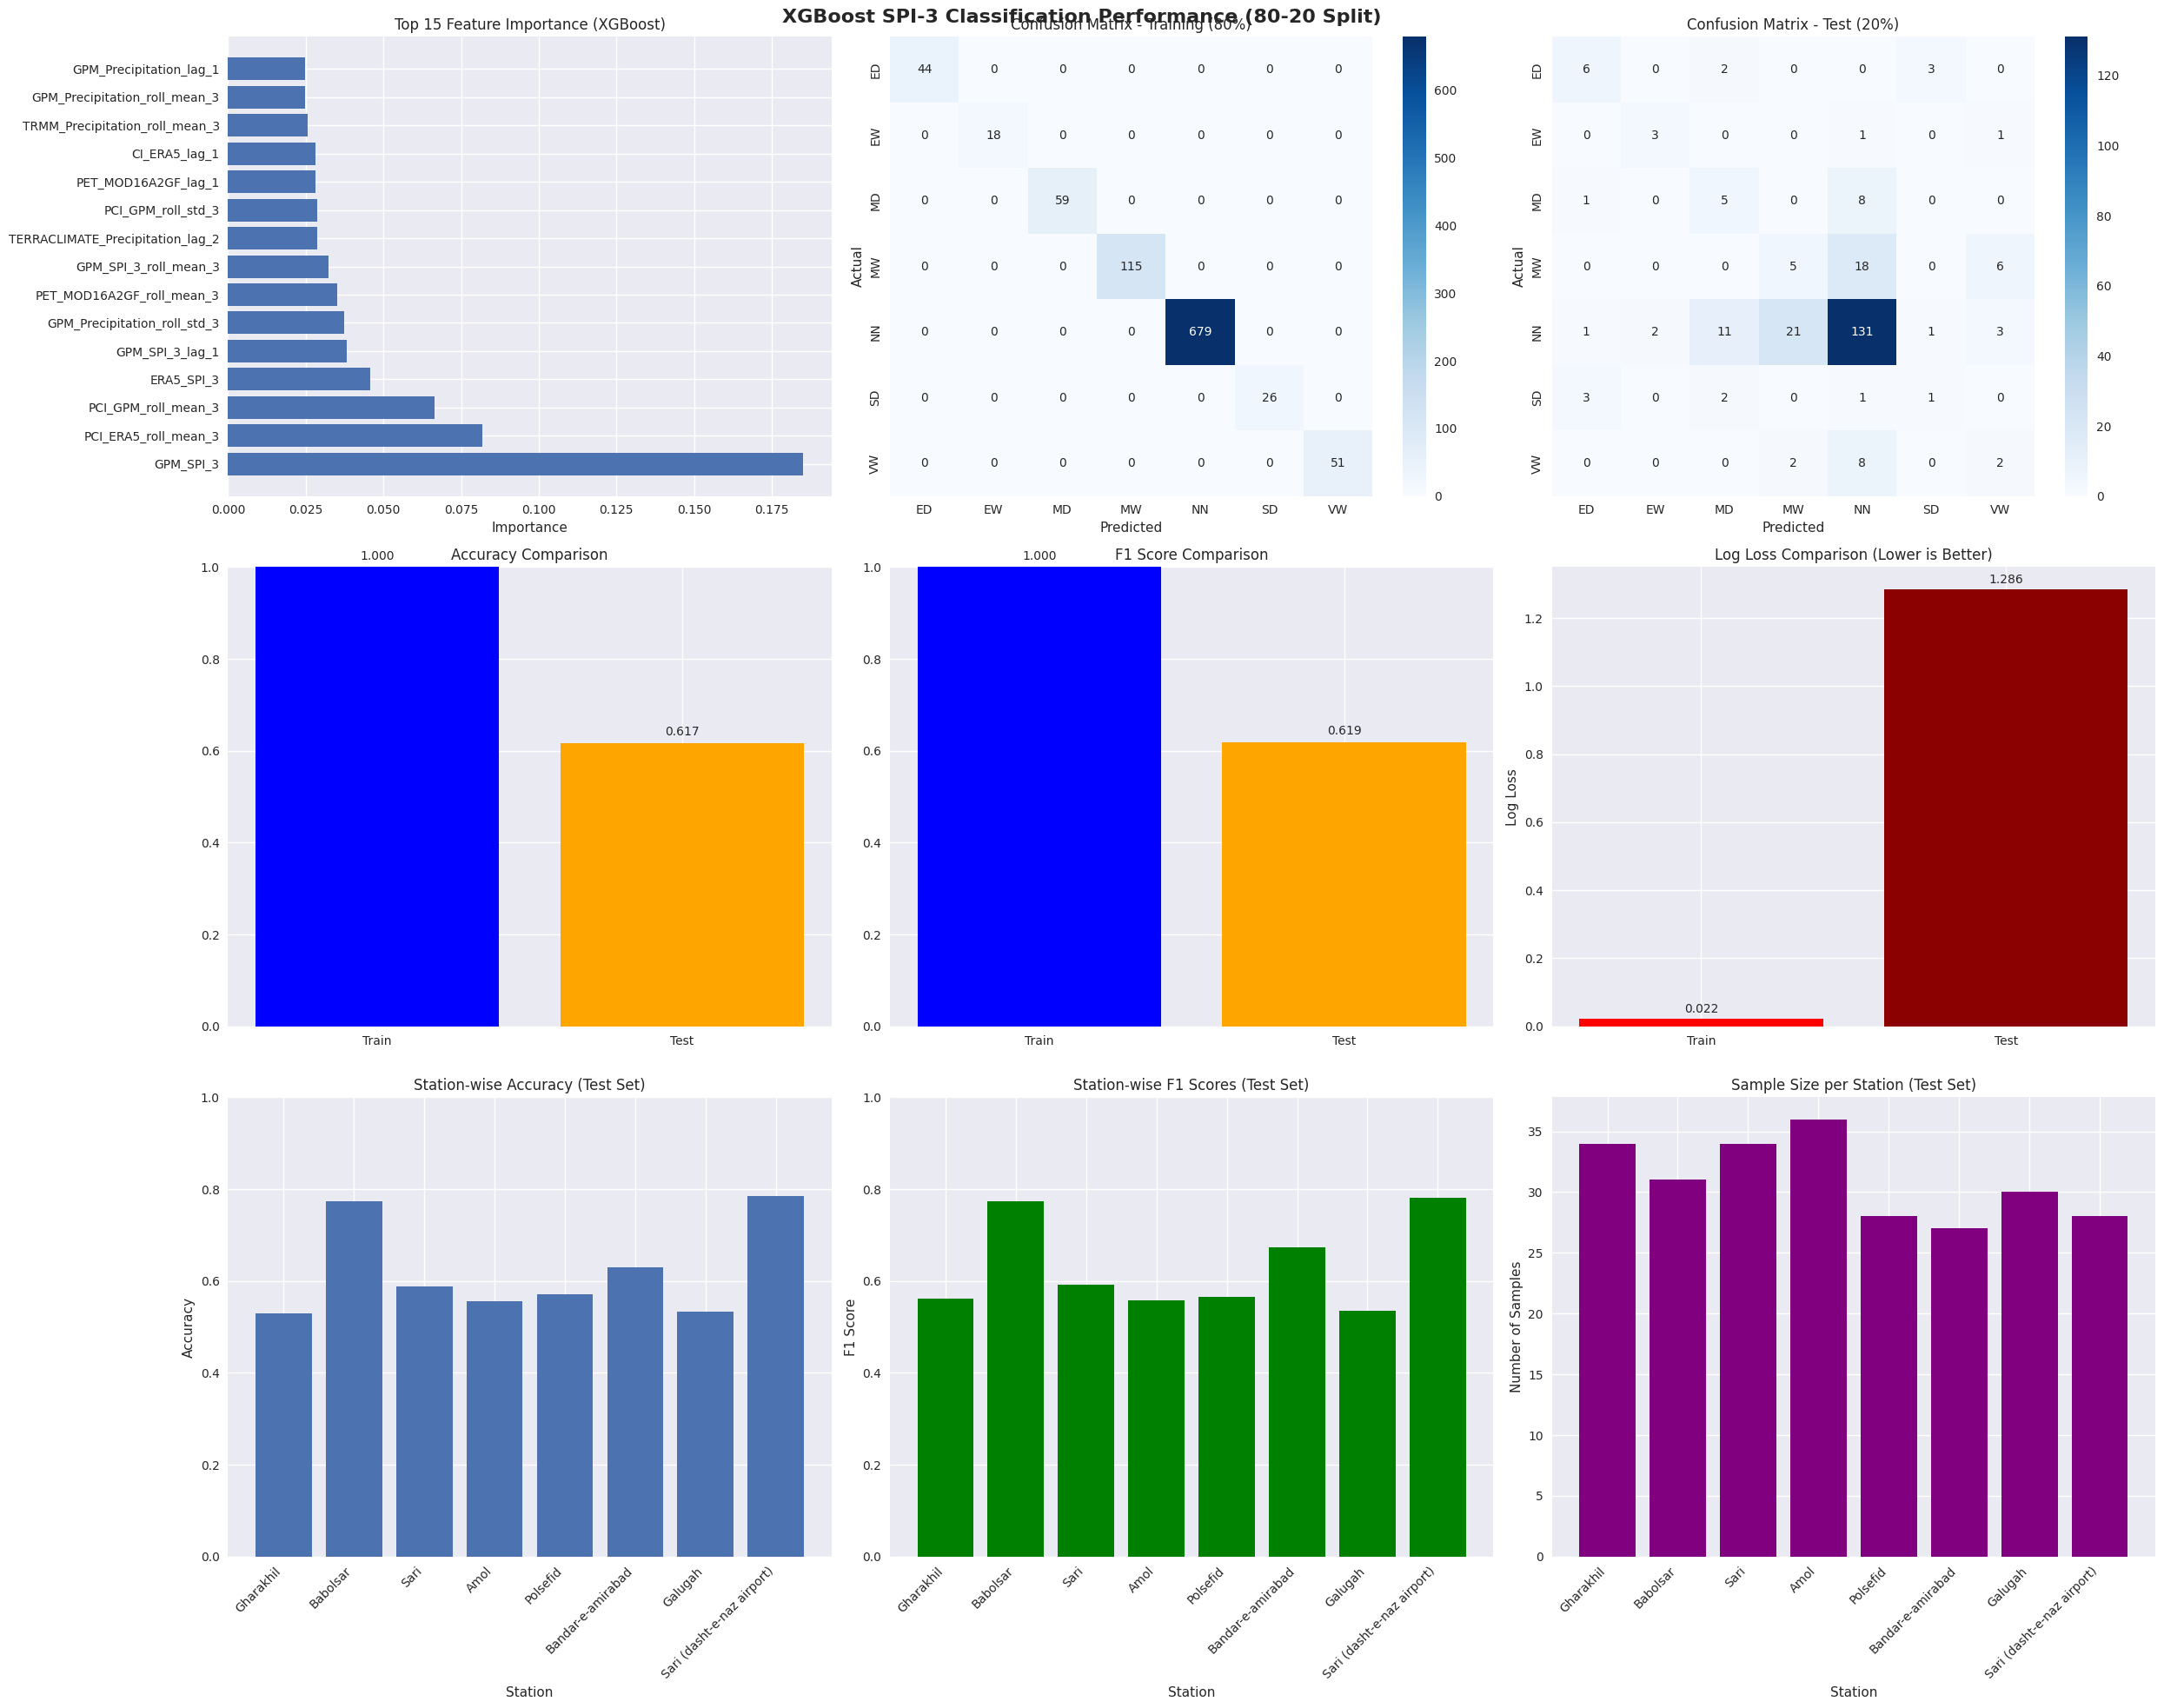

<Figure size 1200x800 with 0 Axes>

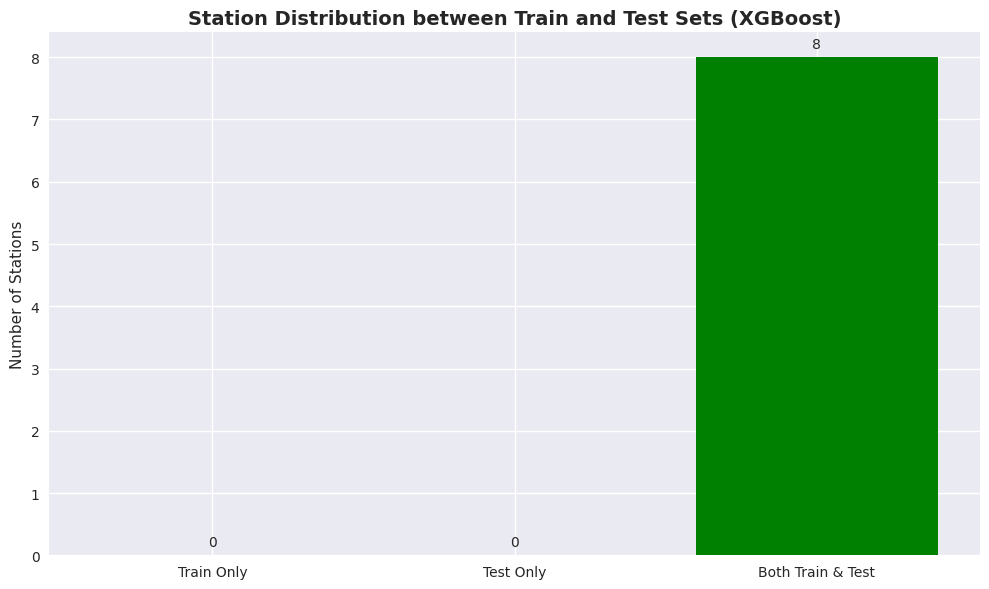


XGBoost model training and evaluation completed successfully!
Visualizations saved as:
- xgb_spi_80_20_split_performance.png
- xgb_station_distribution.png


In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectFromModel, mutual_info_classif
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

class SPI_XGB_Model:
    def __init__(self, df):
        self.df = df.copy()
        self.features = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.model = None
        self.best_params = None
        self.label_encoder = LabelEncoder()
        self.station_scalers = {}  # Store scalers for each station
        
    def station_wise_standardization(self):
        """Standardize features within each station separately"""
        print("Performing station-wise standardization...")
        
        # Identify numeric features to standardize (exclude categorical and target)
        exclude_cols = ['Station_Name', 'Station_ID', 'Date', 'SPI_3_Class', 
                       'Year', 'Month', 'SPI_3', 'SPI_3_Class_encoded']
        numeric_cols = [col for col in self.df.select_dtypes(include=[np.number]).columns 
                       if col not in exclude_cols]
        
        # Standardize within each station
        df_standardized = self.df.copy()
        
        for station in self.df['Station_Name'].unique():
            station_mask = self.df['Station_Name'] == station
            
            # Create and fit scaler for this station
            scaler = StandardScaler()
            station_data = self.df.loc[station_mask, numeric_cols]
            
            if len(station_data) > 0:
                scaled_data = scaler.fit_transform(station_data)
                df_standardized.loc[station_mask, numeric_cols] = scaled_data
                self.station_scalers[station] = scaler
        
        return df_standardized
    
    def preprocess_data(self):
        """Preprocess the data with station-wise standardization"""
        print("Preprocessing data with station-wise standardization...")
        
        # Drop columns with too many missing values
        missing_threshold = 0.3
        missing_ratios = self.df.isnull().mean()
        cols_to_drop = missing_ratios[missing_ratios > missing_threshold].index.tolist()
        self.df = self.df.drop(columns=cols_to_drop)
        
        # Fill remaining missing values with station-specific means
        for col in self.df.select_dtypes(include=[np.number]).columns:
            if col not in ['Station_Name', 'Station_ID']:
                self.df[col] = self.df.groupby('Station_Name')[col].transform(
                    lambda x: x.fillna(x.mean()))
        
        # Encode target variable
        self.df['SPI_3_Class_encoded'] = self.label_encoder.fit_transform(self.df['SPI_3_Class'])
        
        # Apply station-wise standardization
        self.df = self.station_wise_standardization()
        
        return self.df
    
    def select_features(self, method='mutual_info', top_k=30):
        """Select the most important features using multiple methods"""
        print(f"Selecting features using {method} method...")
        
        # Define features to exclude
        exclude_cols = ['Station_Name', 'Station_ID', 'Date', 'SPI_3_Class', 
                       'SPI_3_Class_encoded', 'Year', 'Month', 'SPI_3']
        
        # Get all numeric columns except excluded ones
        all_features = [col for col in self.df.select_dtypes(include=[np.number]).columns 
                       if col not in exclude_cols]
        
        X = self.df[all_features]
        y = self.df['SPI_3_Class_encoded']
        
        if method == 'mutual_info':
            # Mutual information feature selection
            mi_scores = mutual_info_classif(X, y, random_state=42)
            mi_df = pd.DataFrame({'feature': all_features, 'mi_score': mi_scores})
            mi_df = mi_df.sort_values('mi_score', ascending=False)
            selected_features = mi_df.head(top_k)['feature'].tolist()
            
        elif method == 'xgb_importance':
            # XGBoost feature importance
            xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False)
            xgb_model.fit(X, y)
            selector = SelectFromModel(xgb_model, prefit=True, threshold='median')
            selected_features = X.columns[selector.get_support()].tolist()
            
        elif method == 'correlation':
            # Correlation with target
            corr_scores = []
            for feature in all_features:
                if len(self.df[feature].unique()) > 1:  # Avoid constant features
                    corr = np.corrcoef(self.df[feature], y)[0, 1]
                    corr_scores.append(abs(corr))
                else:
                    corr_scores.append(0)
            
            corr_df = pd.DataFrame({'feature': all_features, 'corr_score': corr_scores})
            corr_df = corr_df.sort_values('corr_score', ascending=False)
            selected_features = corr_df.head(top_k)['feature'].tolist()
        
        print(f"Selected {len(selected_features)} features out of {len(all_features)}")
        self.features = selected_features
        
        return selected_features
    
    def prepare_train_test(self, test_size=0.2):
        """Prepare 80-20 train-test split on the entire dataset"""
        print("Preparing 80-20 train-test split on entire dataset...")
        
        X = self.df[self.features]
        y = self.df['SPI_3_Class_encoded']
        
        # Regular random 80-20 split
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=y
        )
        
        # Store station information for analysis
        self.train_stations = self.df.iloc[self.X_train.index]['Station_Name'].unique()
        self.test_stations = self.df.iloc[self.X_test.index]['Station_Name'].unique()
        
        print(f"Training samples: {len(self.X_train)}")
        print(f"Test samples: {len(self.X_test)}")
        print(f"Unique stations in training: {len(self.train_stations)}")
        print(f"Unique stations in test: {len(self.test_stations)}")
        print(f"Stations in both train and test: {len(set(self.train_stations) & set(self.test_stations))}")
        
        return self.X_train, self.X_test, self.y_train, self.y_test
    
    def get_hyperparameter_space(self):
        """Define hyperparameter search space for XGBoost"""
        param_dist = {
            'xgb__n_estimators': [100, 200, 300, 500],
            'xgb__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
            'xgb__max_depth': [3, 5, 7, 9, 11],
            'xgb__min_child_weight': [1, 3, 5, 7],
            'xgb__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
            'xgb__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
            'xgb__gamma': [0, 0.1, 0.2, 0.3, 0.4],
            'xgb__reg_alpha': [0, 0.1, 0.5, 1.0],
            'xgb__reg_lambda': [0.5, 1.0, 1.5, 2.0],
            'xgb__random_state': [42]
        }
        return param_dist
    
    def train_model(self, n_iter=50, cv=3):
        """Train the model with hyperparameter tuning and SMOTE"""
        print("Training XGBoost model with hyperparameter tuning...")
        
        # Create pipeline with SMOTE and XGBoost
        pipeline = ImbPipeline([
            ('smote', SMOTE(random_state=42)),
            ('xgb', xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'))
        ])
        
        # Hyperparameter tuning
        param_dist = self.get_hyperparameter_space()
        random_search = RandomizedSearchCV(
            pipeline, param_dist, n_iter=n_iter, cv=cv, 
            scoring='f1_weighted', random_state=42, n_jobs=-1, verbose=1
        )
        
        random_search.fit(self.X_train, self.y_train)
        
        self.model = random_search.best_estimator_
        self.best_params = random_search.best_params_
        
        print("Best parameters found:", self.best_params)
        return self.model
    
    def evaluate_model(self):
        """Comprehensive model evaluation with station-wise analysis"""
        print("Evaluating model...")
        
        # Predictions
        y_pred_train = self.model.predict(self.X_train)
        y_pred_test = self.model.predict(self.X_test)
        y_pred_proba_train = self.model.predict_proba(self.X_train)
        y_pred_proba_test = self.model.predict_proba(self.X_test)
        
        # Convert back to original labels
        y_train_orig = self.label_encoder.inverse_transform(self.y_train)
        y_test_orig = self.label_encoder.inverse_transform(self.y_test)
        y_pred_train_orig = self.label_encoder.inverse_transform(y_pred_train)
        y_pred_test_orig = self.label_encoder.inverse_transform(y_pred_test)
        
        # Calculate overall metrics
        train_accuracy = accuracy_score(y_train_orig, y_pred_train_orig)
        test_accuracy = accuracy_score(y_test_orig, y_pred_test_orig)
        train_f1 = f1_score(y_train_orig, y_pred_train_orig, average='weighted')
        test_f1 = f1_score(y_test_orig, y_pred_test_orig, average='weighted')
        
        # Calculate log loss
        train_log_loss = self._calculate_log_loss(self.y_train, y_pred_proba_train)
        test_log_loss = self._calculate_log_loss(self.y_test, y_pred_proba_test)
        
        # Station-wise performance
        station_performance = self._calculate_station_performance()
        
        # Classification reports
        train_report = classification_report(y_train_orig, y_pred_train_orig)
        test_report = classification_report(y_test_orig, y_pred_test_orig)
        
        # Confusion matrices
        train_cm = confusion_matrix(y_train_orig, y_pred_train_orig)
        test_cm = confusion_matrix(y_test_orig, y_pred_test_orig)
        
        results = {
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy,
            'train_f1': train_f1,
            'test_f1': test_f1,
            'train_log_loss': train_log_loss,
            'test_log_loss': test_log_loss,
            'train_report': train_report,
            'test_report': test_report,
            'train_cm': train_cm,
            'test_cm': test_cm,
            'feature_importance': self.get_feature_importance(),
            'class_names': self.label_encoder.classes_,
            'station_performance': station_performance,
            'train_stations': self.train_stations,
            'test_stations': self.test_stations
        }
        
        return results
    
    def _calculate_log_loss(self, y_true, y_pred_proba):
        """Calculate multi-class log loss"""
        from sklearn.metrics import log_loss
        return log_loss(y_true, y_pred_proba)
    
    def _calculate_station_performance(self):
        """Calculate performance metrics for each station"""
        station_performance = {}
        
        # Add station information to test data
        test_df = self.X_test.copy()
        test_df['true_class'] = self.y_test.values
        test_df['pred_class'] = self.model.predict(self.X_test)
        test_df['station'] = self.df.iloc[self.X_test.index]['Station_Name'].values
        
        for station in test_df['station'].unique():
            station_data = test_df[test_df['station'] == station]
            if len(station_data) > 0:
                accuracy = accuracy_score(station_data['true_class'], station_data['pred_class'])
                f1 = f1_score(station_data['true_class'], station_data['pred_class'], 
                             average='weighted')
                station_performance[station] = {
                    'accuracy': accuracy,
                    'f1_score': f1,
                    'n_samples': len(station_data)
                }
        
        return station_performance
    
    def get_feature_importance(self):
        """Get feature importance from the trained XGBoost model"""
        xgb_model = self.model.named_steps['xgb']
        importance_df = pd.DataFrame({
            'feature': self.features,
            'importance': xgb_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        return importance_df
    
    def generate_summary(self, results):
        """Generate comprehensive summary with station-wise analysis"""
        print("\n" + "="*60)
        print("XGBOOST MODEL SUMMARY")
        print("="*60)
        
        print(f"\nBest Parameters: {self.best_params}")
        print(f"\nOverall Performance:")
        print(f"Train Accuracy: {results['train_accuracy']:.4f}")
        print(f"Test Accuracy: {results['test_accuracy']:.4f}")
        print(f"Train F1 Score: {results['train_f1']:.4f}")
        print(f"Test F1 Score: {results['test_f1']:.4f}")
        print(f"Train Log Loss: {results['train_log_loss']:.4f}")
        print(f"Test Log Loss: {results['test_log_loss']:.4f}")
        
        print(f"\nTraining Samples: {len(self.X_train)}")
        print(f"Test Samples: {len(self.X_test)}")
        print(f"Unique stations in training: {len(results['train_stations'])}")
        print(f"Unique stations in test: {len(results['test_stations'])}")
        
        print("\nTop 10 Most Important Features:")
        print(results['feature_importance'].head(10).to_string(index=False))
        
        print("\nStation-wise Performance (Test Set):")
        for station, metrics in results['station_performance'].items():
            print(f"{station}: Accuracy={metrics['accuracy']:.3f}, F1={metrics['f1_score']:.3f}, Samples={metrics['n_samples']}")
        
        print("\nTraining Classification Report:")
        print(results['train_report'])
        
        print("\nTest Classification Report:")
        print(results['test_report'])
    
    def create_visualizations(self, results):
        """Create comprehensive visualizations including station-wise analysis"""
        print("Creating visualizations...")
        
        # Set style
        plt.style.use('seaborn-v0_8')
        fig, axes = plt.subplots(3, 3, figsize=(25, 20))
        fig.suptitle('XGBoost SPI-3 Classification Performance (80-20 Split)', 
                    fontsize=16, fontweight='bold')
        
        # 1. Feature Importance Plot
        top_features = results['feature_importance'].head(15)
        axes[0, 0].barh(range(len(top_features)), top_features['importance'])
        axes[0, 0].set_yticks(range(len(top_features)))
        axes[0, 0].set_yticklabels(top_features['feature'])
        axes[0, 0].set_title('Top 15 Feature Importance (XGBoost)')
        axes[0, 0].set_xlabel('Importance')
        
        # 2. Confusion Matrix - Train
        sns.heatmap(results['train_cm'], annot=True, fmt='d', cmap='Blues',
                   xticklabels=results['class_names'],
                   yticklabels=results['class_names'], ax=axes[0, 1])
        axes[0, 1].set_title('Confusion Matrix - Training (80%)')
        axes[0, 1].set_xlabel('Predicted')
        axes[0, 1].set_ylabel('Actual')
        
        # 3. Confusion Matrix - Test
        sns.heatmap(results['test_cm'], annot=True, fmt='d', cmap='Blues',
                   xticklabels=results['class_names'],
                   yticklabels=results['class_names'], ax=axes[0, 2])
        axes[0, 2].set_title('Confusion Matrix - Test (20%)')
        axes[0, 2].set_xlabel('Predicted')
        axes[0, 2].set_ylabel('Actual')
        
        # 4. Accuracy Comparison
        acc_data = pd.DataFrame({
            'Dataset': ['Train', 'Test'],
            'Accuracy': [results['train_accuracy'], results['test_accuracy']]
        })
        axes[1, 0].bar(acc_data['Dataset'], acc_data['Accuracy'], color=['blue', 'orange'])
        axes[1, 0].set_title('Accuracy Comparison')
        axes[1, 0].set_ylim(0, 1)
        for i, v in enumerate(acc_data['Accuracy']):
            axes[1, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
        
        # 5. F1 Score Comparison
        f1_data = pd.DataFrame({
            'Dataset': ['Train', 'Test'],
            'F1_Score': [results['train_f1'], results['test_f1']]
        })
        axes[1, 1].bar(f1_data['Dataset'], f1_data['F1_Score'], color=['blue', 'orange'])
        axes[1, 1].set_title('F1 Score Comparison')
        axes[1, 1].set_ylim(0, 1)
        for i, v in enumerate(f1_data['F1_Score']):
            axes[1, 1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
        
        # 6. Log Loss Comparison
        log_loss_data = pd.DataFrame({
            'Dataset': ['Train', 'Test'],
            'Log_Loss': [results['train_log_loss'], results['test_log_loss']]
        })
        axes[1, 2].bar(log_loss_data['Dataset'], log_loss_data['Log_Loss'], color=['red', 'darkred'])
        axes[1, 2].set_title('Log Loss Comparison (Lower is Better)')
        axes[1, 2].set_ylabel('Log Loss')
        for i, v in enumerate(log_loss_data['Log_Loss']):
            axes[1, 2].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
        
        # 7. Station-wise Accuracy
        if results['station_performance']:
            station_acc = [metrics['accuracy'] for metrics in results['station_performance'].values()]
            station_names = list(results['station_performance'].keys())
            axes[2, 0].bar(range(len(station_acc)), station_acc)
            axes[2, 0].set_title('Station-wise Accuracy (Test Set)')
            axes[2, 0].set_xlabel('Station')
            axes[2, 0].set_ylabel('Accuracy')
            axes[2, 0].set_ylim(0, 1)
            axes[2, 0].set_xticks(range(len(station_names)))
            axes[2, 0].set_xticklabels(station_names, rotation=45, ha='right')
        
        # 8. Station F1 Scores
        if results['station_performance']:
            station_f1 = [metrics['f1_score'] for metrics in results['station_performance'].values()]
            axes[2, 1].bar(range(len(station_f1)), station_f1, color='green')
            axes[2, 1].set_title('Station-wise F1 Scores (Test Set)')
            axes[2, 1].set_xlabel('Station')
            axes[2, 1].set_ylabel('F1 Score')
            axes[2, 1].set_ylim(0, 1)
            axes[2, 1].set_xticks(range(len(station_names)))
            axes[2, 1].set_xticklabels(station_names, rotation=45, ha='right')
        
        # 9. Sample Size per Station in Test Set
        if results['station_performance']:
            station_samples = [metrics['n_samples'] for metrics in results['station_performance'].values()]
            axes[2, 2].bar(range(len(station_samples)), station_samples, color='purple')
            axes[2, 2].set_title('Sample Size per Station (Test Set)')
            axes[2, 2].set_xlabel('Station')
            axes[2, 2].set_ylabel('Number of Samples')
            axes[2, 2].set_xticks(range(len(station_names)))
            axes[2, 2].set_xticklabels(station_names, rotation=45, ha='right')
        
        plt.tight_layout()
        plt.savefig('xgb_spi_80_20_split_performance.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Additional: Create training vs test station overlap visualization
        self._create_station_overlap_visualization(results)

    def _create_station_overlap_visualization(self, results):
        """Create visualization showing station overlap between train and test sets"""
        plt.figure(figsize=(12, 8))
        
        train_stations = set(results['train_stations'])
        test_stations = set(results['test_stations'])
        
        # Create Venn diagram-like visualization
        plt.figure(figsize=(10, 6))
        plt.title('Station Distribution between Train and Test Sets (XGBoost)', fontsize=14, fontweight='bold')
        
        # Simple bar chart showing station counts
        categories = ['Train Only', 'Test Only', 'Both Train & Test']
        counts = [
            len(train_stations - test_stations),
            len(test_stations - train_stations),
            len(train_stations & test_stations)
        ]
        
        bars = plt.bar(categories, counts, color=['blue', 'orange', 'green'])
        plt.ylabel('Number of Stations')
        
        # Add value labels on bars
        for bar, count in zip(bars, counts):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                    str(count), ha='center', va='bottom')
        
        plt.tight_layout()
        plt.savefig('xgb_station_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()

# Main execution function
def main():
    # Load your data
    # df = pd.read_csv('your_data.csv')  # Replace with your actual data loading
    
    # Initialize and run the model
    model = SPI_XGB_Model(df)
    
    # Preprocess data with station-wise standardization
    df_processed = model.preprocess_data()
    
    # Select features using multiple methods
    selected_features = model.select_features(method='mutual_info', top_k=30)
    print(f"Selected features: {selected_features}")
    
    # Prepare 80-20 train-test split
    X_train, X_test, y_train, y_test = model.prepare_train_test(test_size=0.2)
    
    # Train model
    trained_model = model.train_model(n_iter=30, cv=3)
    
    # Evaluate model
    results = model.evaluate_model()
    
    # Generate summary
    model.generate_summary(results)
    
    # Create visualizations
    model.create_visualizations(results)
    
    print("\nXGBoost model training and evaluation completed successfully!")
    print("Visualizations saved as:")
    print("- xgb_spi_80_20_split_performance.png")
    print("- xgb_station_distribution.png")

if __name__ == "__main__":
    main()

Preprocessing data with station-wise standardization...
Performing station-wise standardization...
Selecting features using mutual_info method...
Selected 26 features out of 26
Selected features: ['GPM_SPI_3', 'ERA5_SPI_3', 'PCI_GPM', 'CI_GPM', 'TRMM_Precipitation', 'GPM_Precipitation', 'CI_ERA5', 'PERSIANNCDR_Precipitation', 'PET_MOD16A2GF', 'LSTNight', 'LST', 'PCI_ERA5', 'VHI', 'TCI', 'Station_Latitude', 'ERA5_Precipitation', 'LSTDay', 'LST_Diff', 'Station_Longitude', 'Month_cos', 'TERRACLIMATE_Precipitation', 'EVI', 'Month_sin', 'NDVI', 'Station_Elevation', 'VCI']
Preparing 80-20 train-test split on entire dataset...
Training samples: 1011
Test samples: 253
Unique stations in training: 8
Unique stations in test: 8
Stations in both train and test: 8
Training Random Forest model with hyperparameter tuning...
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best parameters found: {'rf__random_state': 42, 'rf__n_estimators': 500, 'rf__min_samples_split': 10, 'rf__min_samples

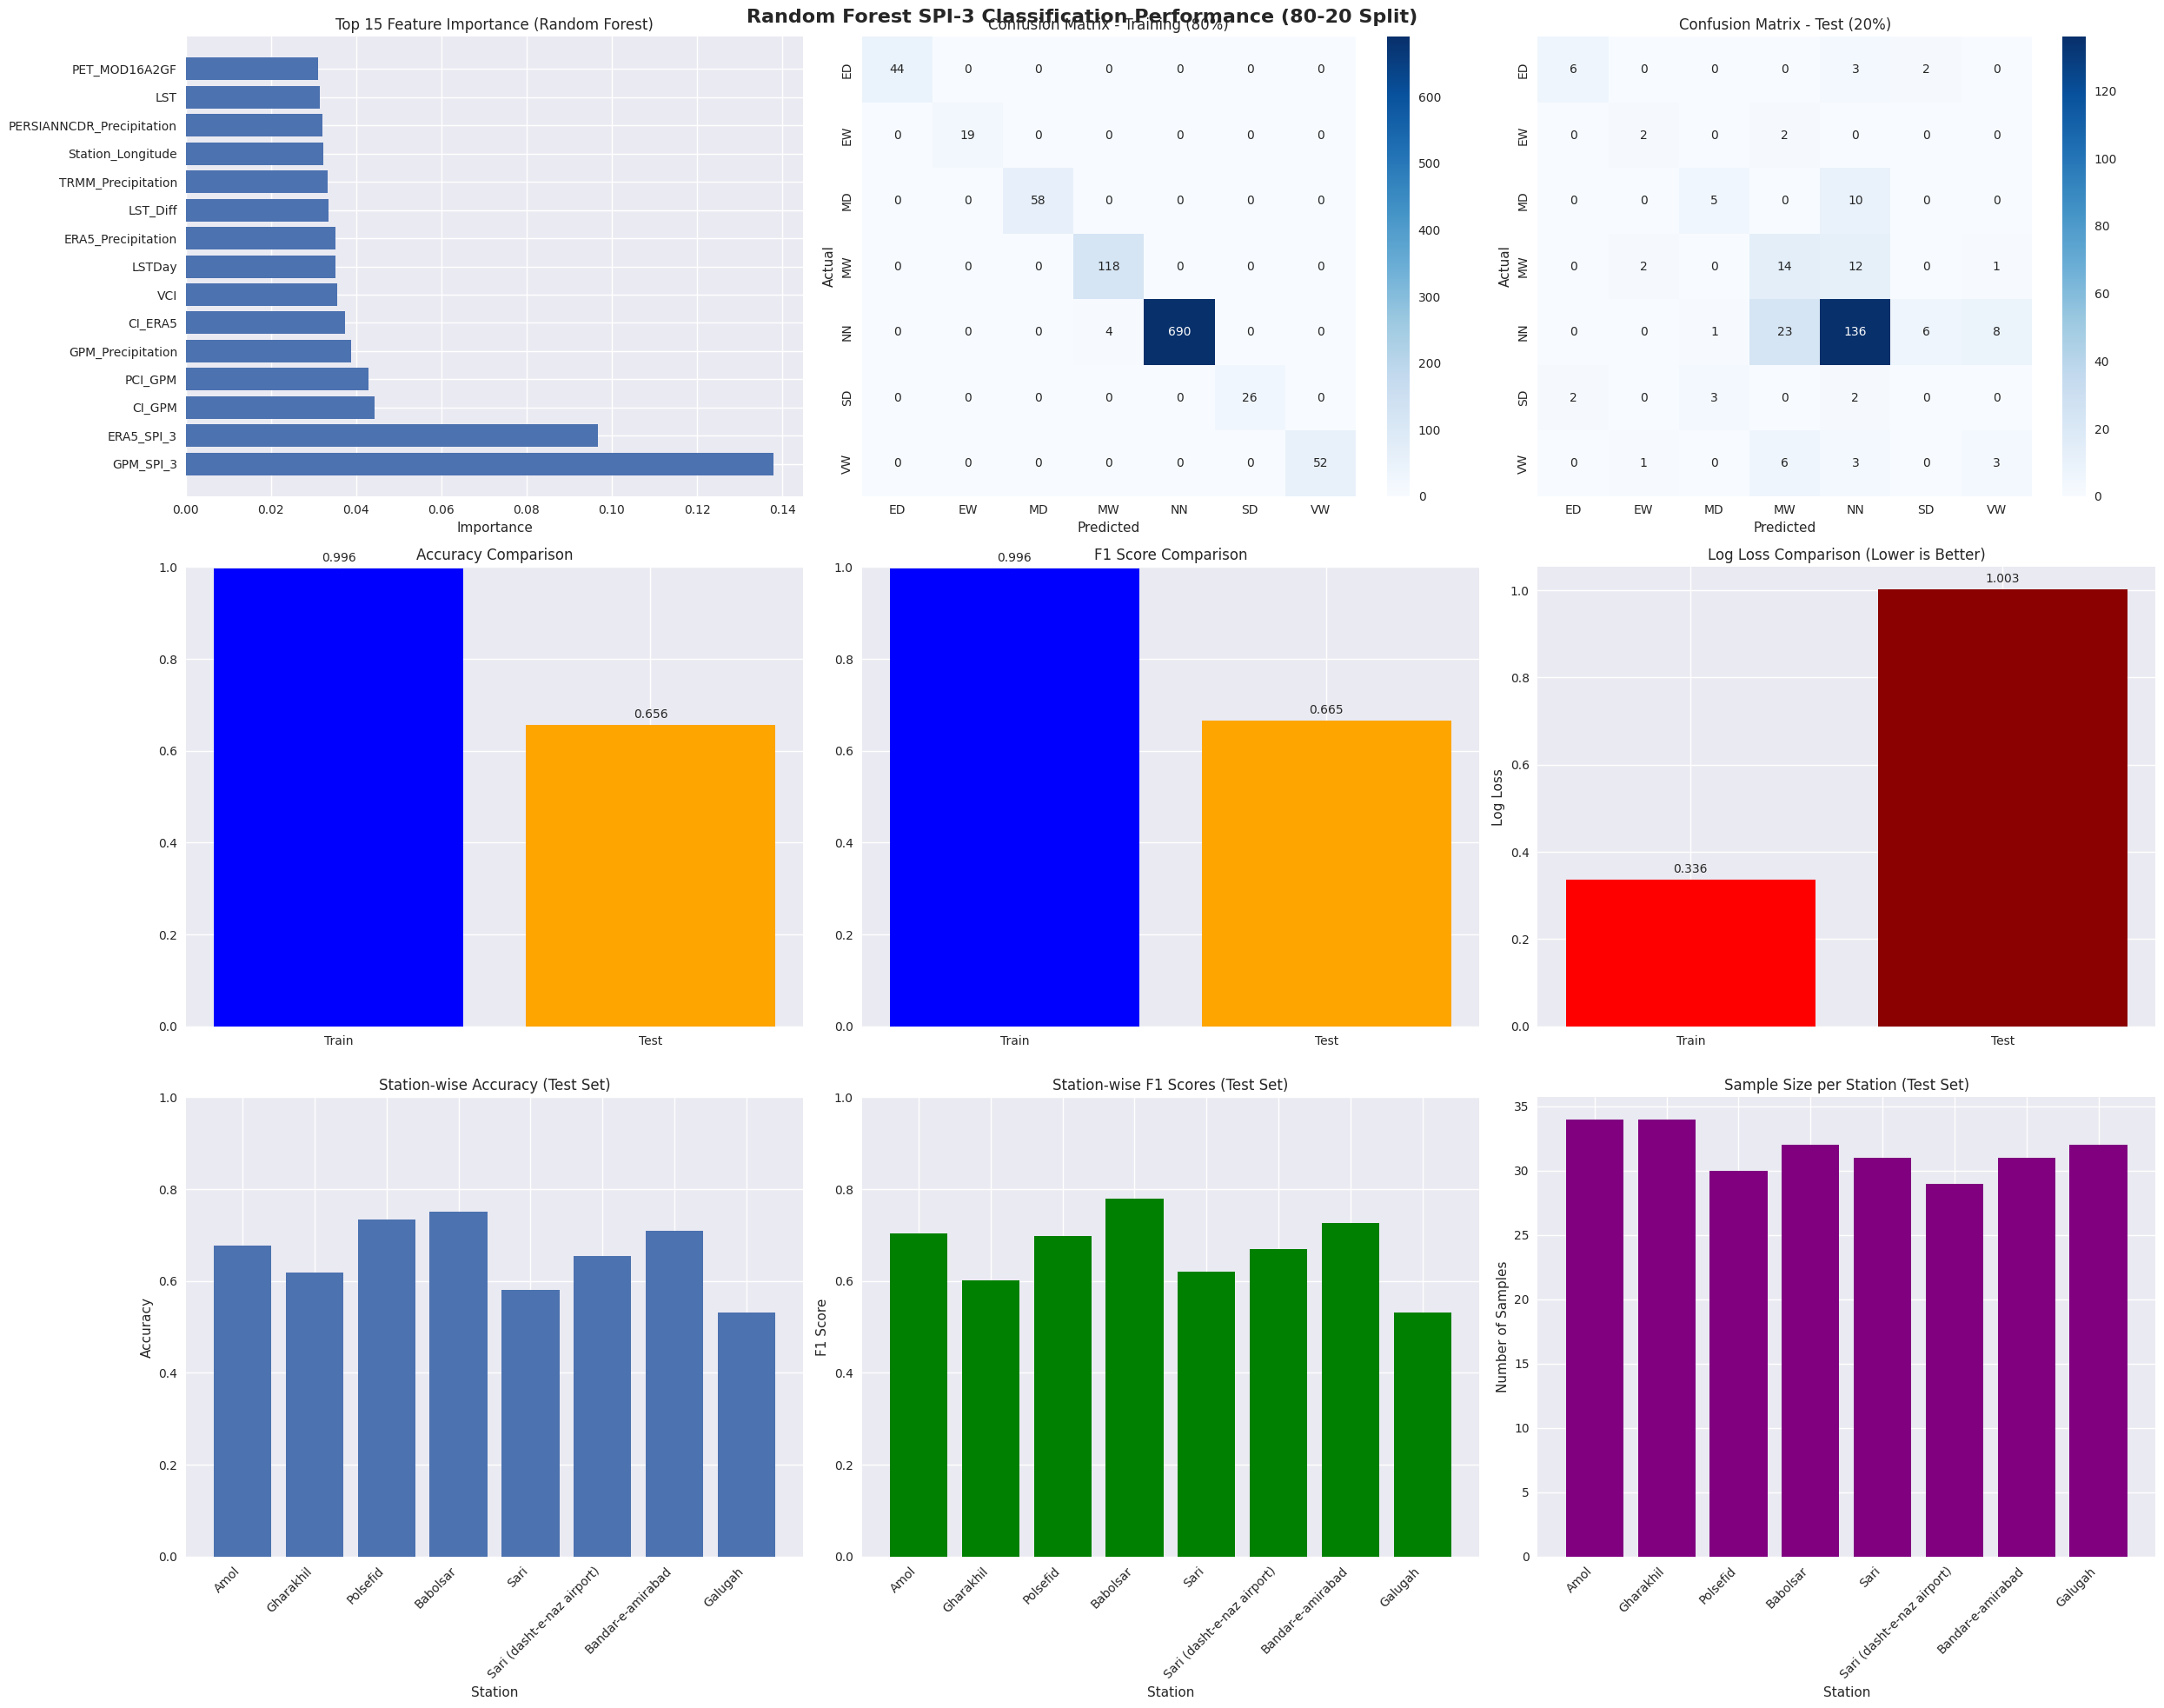

<Figure size 1200x800 with 0 Axes>

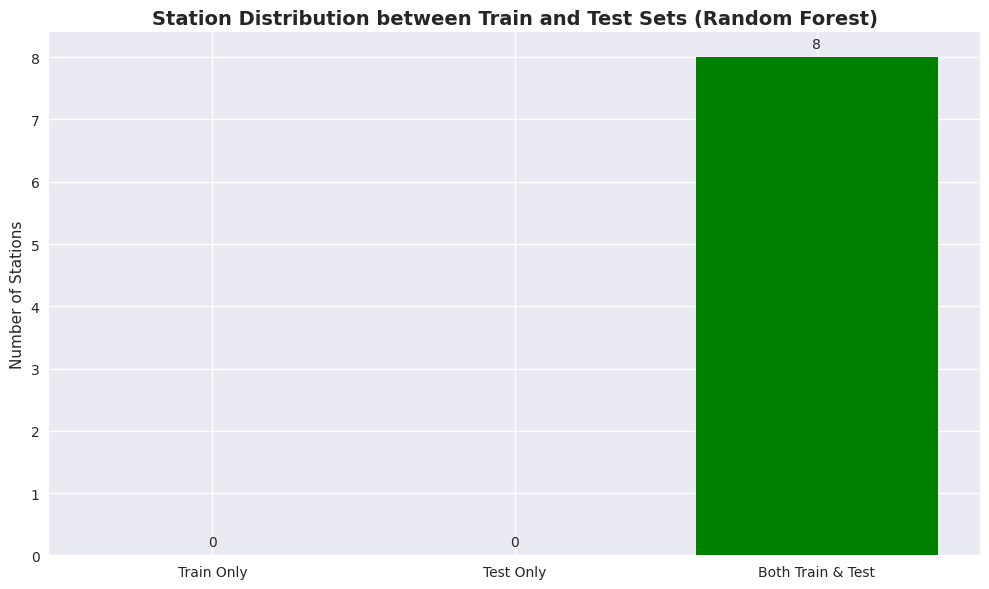


Random Forest model training and evaluation completed successfully!
Visualizations saved as:
- rf_spi_80_20_split_performance.png
- rf_station_distribution.png


In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectFromModel, mutual_info_classif
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

class SPI_RF_Model:
    def __init__(self, df):
        self.df = df.copy()
        self.features = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.model = None
        self.best_params = None
        self.label_encoder = LabelEncoder()
        self.station_scalers = {}  # Store scalers for each station
        
    def station_wise_standardization(self):
        """Standardize features within each station separately"""
        print("Performing station-wise standardization...")
        
        # Identify numeric features to standardize (exclude categorical and target)
        exclude_cols = ['Station_Name', 'Station_ID', 'Date', 'SPI_3_Class', 
                       'Year', 'Month', 'SPI_3', 'SPI_3_Class_encoded']
        numeric_cols = [col for col in self.df.select_dtypes(include=[np.number]).columns 
                       if col not in exclude_cols]
        
        # Standardize within each station
        df_standardized = self.df.copy()
        
        for station in self.df['Station_Name'].unique():
            station_mask = self.df['Station_Name'] == station
            
            # Create and fit scaler for this station
            scaler = StandardScaler()
            station_data = self.df.loc[station_mask, numeric_cols]
            
            if len(station_data) > 0:
                scaled_data = scaler.fit_transform(station_data)
                df_standardized.loc[station_mask, numeric_cols] = scaled_data
                self.station_scalers[station] = scaler
        
        return df_standardized
    
    def preprocess_data(self):
        """Preprocess the data with station-wise standardization"""
        print("Preprocessing data with station-wise standardization...")
        
        # Drop columns with too many missing values
        missing_threshold = 0.3
        missing_ratios = self.df.isnull().mean()
        cols_to_drop = missing_ratios[missing_ratios > missing_threshold].index.tolist()
        self.df = self.df.drop(columns=cols_to_drop)
        
        # Fill remaining missing values with station-specific means
        for col in self.df.select_dtypes(include=[np.number]).columns:
            if col not in ['Station_Name', 'Station_ID']:
                self.df[col] = self.df.groupby('Station_Name')[col].transform(
                    lambda x: x.fillna(x.mean()))
        
        # Encode target variable
        self.df['SPI_3_Class_encoded'] = self.label_encoder.fit_transform(self.df['SPI_3_Class'])
        
        # Apply station-wise standardization
        self.df = self.station_wise_standardization()
        
        return self.df
    
    def select_features(self, method='rf_importance', top_k=30):
        """Select the most important features using multiple methods"""
        print(f"Selecting features using {method} method...")
        
        # Define features to exclude
        exclude_cols = ['Station_Name', 'Station_ID', 'Date', 'SPI_3_Class', 
                       'SPI_3_Class_encoded', 'Year', 'Month', 'SPI_3']
        
        # Get all numeric columns except excluded ones
        all_features = [col for col in self.df.select_dtypes(include=[np.number]).columns 
                       if col not in exclude_cols]
        
        X = self.df[all_features]
        y = self.df['SPI_3_Class_encoded']
        
        if method == 'mutual_info':
            # Mutual information feature selection
            mi_scores = mutual_info_classif(X, y, random_state=42)
            mi_df = pd.DataFrame({'feature': all_features, 'mi_score': mi_scores})
            mi_df = mi_df.sort_values('mi_score', ascending=False)
            selected_features = mi_df.head(top_k)['feature'].tolist()
            
        elif method == 'rf_importance':
            # Random Forest feature importance
            rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
            rf_model.fit(X, y)
            selector = SelectFromModel(rf_model, prefit=True, threshold='median')
            selected_features = X.columns[selector.get_support()].tolist()
            
        elif method == 'correlation':
            # Correlation with target
            corr_scores = []
            for feature in all_features:
                if len(self.df[feature].unique()) > 1:  # Avoid constant features
                    corr = np.corrcoef(self.df[feature], y)[0, 1]
                    corr_scores.append(abs(corr))
                else:
                    corr_scores.append(0)
            
            corr_df = pd.DataFrame({'feature': all_features, 'corr_score': corr_scores})
            corr_df = corr_df.sort_values('corr_score', ascending=False)
            selected_features = corr_df.head(top_k)['feature'].tolist()
        
        print(f"Selected {len(selected_features)} features out of {len(all_features)}")
        self.features = selected_features
        
        return selected_features
    
    def prepare_train_test(self, test_size=0.2):
        """Prepare 80-20 train-test split on the entire dataset"""
        print("Preparing 80-20 train-test split on entire dataset...")
        
        X = self.df[self.features]
        y = self.df['SPI_3_Class_encoded']
        
        # Regular random 80-20 split
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=y
        )
        
        # Store station information for analysis
        self.train_stations = self.df.iloc[self.X_train.index]['Station_Name'].unique()
        self.test_stations = self.df.iloc[self.X_test.index]['Station_Name'].unique()
        
        print(f"Training samples: {len(self.X_train)}")
        print(f"Test samples: {len(self.X_test)}")
        print(f"Unique stations in training: {len(self.train_stations)}")
        print(f"Unique stations in test: {len(self.test_stations)}")
        print(f"Stations in both train and test: {len(set(self.train_stations) & set(self.test_stations))}")
        
        return self.X_train, self.X_test, self.y_train, self.y_test
    
    def get_hyperparameter_space(self):
        """Define hyperparameter search space for Random Forest"""
        param_dist = {
            'rf__n_estimators': [100, 200, 300, 500],
            'rf__max_depth': [None, 10, 20, 30, 50],
            'rf__min_samples_split': [2, 5, 10, 15],
            'rf__min_samples_leaf': [1, 2, 4, 6],
            'rf__max_features': ['sqrt', 'log2', None, 0.5, 0.8],
            'rf__bootstrap': [True, False],
            'rf__class_weight': [None, 'balanced', 'balanced_subsample'],
            'rf__random_state': [42]
        }
        return param_dist
    
    def train_model(self, n_iter=50, cv=3):
        """Train the model with hyperparameter tuning and SMOTE"""
        print("Training Random Forest model with hyperparameter tuning...")
        
        # Create pipeline with SMOTE and Random Forest
        pipeline = ImbPipeline([
            ('smote', SMOTE(random_state=42)),
            ('rf', RandomForestClassifier(random_state=42))
        ])
        
        # Hyperparameter tuning
        param_dist = self.get_hyperparameter_space()
        random_search = RandomizedSearchCV(
            pipeline, param_dist, n_iter=n_iter, cv=cv, 
            scoring='f1_weighted', random_state=42, n_jobs=-1, verbose=1
        )
        
        random_search.fit(self.X_train, self.y_train)
        
        self.model = random_search.best_estimator_
        self.best_params = random_search.best_params_
        
        print("Best parameters found:", self.best_params)
        return self.model
    
    def evaluate_model(self):
        """Comprehensive model evaluation with station-wise analysis"""
        print("Evaluating model...")
        
        # Predictions
        y_pred_train = self.model.predict(self.X_train)
        y_pred_test = self.model.predict(self.X_test)
        y_pred_proba_train = self.model.predict_proba(self.X_train)
        y_pred_proba_test = self.model.predict_proba(self.X_test)
        
        # Convert back to original labels
        y_train_orig = self.label_encoder.inverse_transform(self.y_train)
        y_test_orig = self.label_encoder.inverse_transform(self.y_test)
        y_pred_train_orig = self.label_encoder.inverse_transform(y_pred_train)
        y_pred_test_orig = self.label_encoder.inverse_transform(y_pred_test)
        
        # Calculate overall metrics
        train_accuracy = accuracy_score(y_train_orig, y_pred_train_orig)
        test_accuracy = accuracy_score(y_test_orig, y_pred_test_orig)
        train_f1 = f1_score(y_train_orig, y_pred_train_orig, average='weighted')
        test_f1 = f1_score(y_test_orig, y_pred_test_orig, average='weighted')
        
        # Calculate log loss
        train_log_loss = self._calculate_log_loss(self.y_train, y_pred_proba_train)
        test_log_loss = self._calculate_log_loss(self.y_test, y_pred_proba_test)
        
        # Station-wise performance
        station_performance = self._calculate_station_performance()
        
        # Classification reports
        train_report = classification_report(y_train_orig, y_pred_train_orig)
        test_report = classification_report(y_test_orig, y_pred_test_orig)
        
        # Confusion matrices
        train_cm = confusion_matrix(y_train_orig, y_pred_train_orig)
        test_cm = confusion_matrix(y_test_orig, y_pred_test_orig)
        
        results = {
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy,
            'train_f1': train_f1,
            'test_f1': test_f1,
            'train_log_loss': train_log_loss,
            'test_log_loss': test_log_loss,
            'train_report': train_report,
            'test_report': test_report,
            'train_cm': train_cm,
            'test_cm': test_cm,
            'feature_importance': self.get_feature_importance(),
            'class_names': self.label_encoder.classes_,
            'station_performance': station_performance,
            'train_stations': self.train_stations,
            'test_stations': self.test_stations
        }
        
        return results
    
    def _calculate_log_loss(self, y_true, y_pred_proba):
        """Calculate multi-class log loss"""
        from sklearn.metrics import log_loss
        return log_loss(y_true, y_pred_proba)
    
    def _calculate_station_performance(self):
        """Calculate performance metrics for each station"""
        station_performance = {}
        
        # Add station information to test data
        test_df = self.X_test.copy()
        test_df['true_class'] = self.y_test.values
        test_df['pred_class'] = self.model.predict(self.X_test)
        test_df['station'] = self.df.iloc[self.X_test.index]['Station_Name'].values
        
        for station in test_df['station'].unique():
            station_data = test_df[test_df['station'] == station]
            if len(station_data) > 0:
                accuracy = accuracy_score(station_data['true_class'], station_data['pred_class'])
                f1 = f1_score(station_data['true_class'], station_data['pred_class'], 
                             average='weighted')
                station_performance[station] = {
                    'accuracy': accuracy,
                    'f1_score': f1,
                    'n_samples': len(station_data)
                }
        
        return station_performance
    
    def get_feature_importance(self):
        """Get feature importance from the trained Random Forest model"""
        rf_model = self.model.named_steps['rf']
        importance_df = pd.DataFrame({
            'feature': self.features,
            'importance': rf_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        return importance_df
    
    def generate_summary(self, results):
        """Generate comprehensive summary with station-wise analysis"""
        print("\n" + "="*60)
        print("RANDOM FOREST MODEL SUMMARY")
        print("="*60)
        
        print(f"\nBest Parameters: {self.best_params}")
        print(f"\nOverall Performance:")
        print(f"Train Accuracy: {results['train_accuracy']:.4f}")
        print(f"Test Accuracy: {results['test_accuracy']:.4f}")
        print(f"Train F1 Score: {results['train_f1']:.4f}")
        print(f"Test F1 Score: {results['test_f1']:.4f}")
        print(f"Train Log Loss: {results['train_log_loss']:.4f}")
        print(f"Test Log Loss: {results['test_log_loss']:.4f}")
        
        print(f"\nTraining Samples: {len(self.X_train)}")
        print(f"Test Samples: {len(self.X_test)}")
        print(f"Unique stations in training: {len(results['train_stations'])}")
        print(f"Unique stations in test: {len(results['test_stations'])}")
        
        print("\nTop 10 Most Important Features:")
        print(results['feature_importance'].head(10).to_string(index=False))
        
        print("\nStation-wise Performance (Test Set):")
        for station, metrics in results['station_performance'].items():
            print(f"{station}: Accuracy={metrics['accuracy']:.3f}, F1={metrics['f1_score']:.3f}, Samples={metrics['n_samples']}")
        
        print("\nTraining Classification Report:")
        print(results['train_report'])
        
        print("\nTest Classification Report:")
        print(results['test_report'])
    
    def create_visualizations(self, results):
        """Create comprehensive visualizations including station-wise analysis"""
        print("Creating visualizations...")
        
        # Set style
        plt.style.use('seaborn-v0_8')
        fig, axes = plt.subplots(3, 3, figsize=(25, 20))
        fig.suptitle('Random Forest SPI-3 Classification Performance (80-20 Split)', 
                    fontsize=16, fontweight='bold')
        
        # 1. Feature Importance Plot
        top_features = results['feature_importance'].head(15)
        axes[0, 0].barh(range(len(top_features)), top_features['importance'])
        axes[0, 0].set_yticks(range(len(top_features)))
        axes[0, 0].set_yticklabels(top_features['feature'])
        axes[0, 0].set_title('Top 15 Feature Importance (Random Forest)')
        axes[0, 0].set_xlabel('Importance')
        
        # 2. Confusion Matrix - Train
        sns.heatmap(results['train_cm'], annot=True, fmt='d', cmap='Blues',
                   xticklabels=results['class_names'],
                   yticklabels=results['class_names'], ax=axes[0, 1])
        axes[0, 1].set_title('Confusion Matrix - Training (80%)')
        axes[0, 1].set_xlabel('Predicted')
        axes[0, 1].set_ylabel('Actual')
        
        # 3. Confusion Matrix - Test
        sns.heatmap(results['test_cm'], annot=True, fmt='d', cmap='Blues',
                   xticklabels=results['class_names'],
                   yticklabels=results['class_names'], ax=axes[0, 2])
        axes[0, 2].set_title('Confusion Matrix - Test (20%)')
        axes[0, 2].set_xlabel('Predicted')
        axes[0, 2].set_ylabel('Actual')
        
        # 4. Accuracy Comparison
        acc_data = pd.DataFrame({
            'Dataset': ['Train', 'Test'],
            'Accuracy': [results['train_accuracy'], results['test_accuracy']]
        })
        axes[1, 0].bar(acc_data['Dataset'], acc_data['Accuracy'], color=['blue', 'orange'])
        axes[1, 0].set_title('Accuracy Comparison')
        axes[1, 0].set_ylim(0, 1)
        for i, v in enumerate(acc_data['Accuracy']):
            axes[1, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
        
        # 5. F1 Score Comparison
        f1_data = pd.DataFrame({
            'Dataset': ['Train', 'Test'],
            'F1_Score': [results['train_f1'], results['test_f1']]
        })
        axes[1, 1].bar(f1_data['Dataset'], f1_data['F1_Score'], color=['blue', 'orange'])
        axes[1, 1].set_title('F1 Score Comparison')
        axes[1, 1].set_ylim(0, 1)
        for i, v in enumerate(f1_data['F1_Score']):
            axes[1, 1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
        
        # 6. Log Loss Comparison
        log_loss_data = pd.DataFrame({
            'Dataset': ['Train', 'Test'],
            'Log_Loss': [results['train_log_loss'], results['test_log_loss']]
        })
        axes[1, 2].bar(log_loss_data['Dataset'], log_loss_data['Log_Loss'], color=['red', 'darkred'])
        axes[1, 2].set_title('Log Loss Comparison (Lower is Better)')
        axes[1, 2].set_ylabel('Log Loss')
        for i, v in enumerate(log_loss_data['Log_Loss']):
            axes[1, 2].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
        
        # 7. Station-wise Accuracy
        if results['station_performance']:
            station_acc = [metrics['accuracy'] for metrics in results['station_performance'].values()]
            station_names = list(results['station_performance'].keys())
            axes[2, 0].bar(range(len(station_acc)), station_acc)
            axes[2, 0].set_title('Station-wise Accuracy (Test Set)')
            axes[2, 0].set_xlabel('Station')
            axes[2, 0].set_ylabel('Accuracy')
            axes[2, 0].set_ylim(0, 1)
            axes[2, 0].set_xticks(range(len(station_names)))
            axes[2, 0].set_xticklabels(station_names, rotation=45, ha='right')
        
        # 8. Station F1 Scores
        if results['station_performance']:
            station_f1 = [metrics['f1_score'] for metrics in results['station_performance'].values()]
            axes[2, 1].bar(range(len(station_f1)), station_f1, color='green')
            axes[2, 1].set_title('Station-wise F1 Scores (Test Set)')
            axes[2, 1].set_xlabel('Station')
            axes[2, 1].set_ylabel('F1 Score')
            axes[2, 1].set_ylim(0, 1)
            axes[2, 1].set_xticks(range(len(station_names)))
            axes[2, 1].set_xticklabels(station_names, rotation=45, ha='right')
        
        # 9. Sample Size per Station in Test Set
        if results['station_performance']:
            station_samples = [metrics['n_samples'] for metrics in results['station_performance'].values()]
            axes[2, 2].bar(range(len(station_samples)), station_samples, color='purple')
            axes[2, 2].set_title('Sample Size per Station (Test Set)')
            axes[2, 2].set_xlabel('Station')
            axes[2, 2].set_ylabel('Number of Samples')
            axes[2, 2].set_xticks(range(len(station_names)))
            axes[2, 2].set_xticklabels(station_names, rotation=45, ha='right')
        
        plt.tight_layout()
        plt.savefig('rf_spi_80_20_split_performance.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Additional: Create training vs test station overlap visualization
        self._create_station_overlap_visualization(results)

    def _create_station_overlap_visualization(self, results):
        """Create visualization showing station overlap between train and test sets"""
        plt.figure(figsize=(12, 8))
        
        train_stations = set(results['train_stations'])
        test_stations = set(results['test_stations'])
        
        # Create Venn diagram-like visualization
        plt.figure(figsize=(10, 6))
        plt.title('Station Distribution between Train and Test Sets (Random Forest)', fontsize=14, fontweight='bold')
        
        # Simple bar chart showing station counts
        categories = ['Train Only', 'Test Only', 'Both Train & Test']
        counts = [
            len(train_stations - test_stations),
            len(test_stations - train_stations),
            len(train_stations & test_stations)
        ]
        
        bars = plt.bar(categories, counts, color=['blue', 'orange', 'green'])
        plt.ylabel('Number of Stations')
        
        # Add value labels on bars
        for bar, count in zip(bars, counts):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                    str(count), ha='center', va='bottom')
        
        plt.tight_layout()
        plt.savefig('rf_station_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()

# Main execution function
def main():
    # Load your data
    # df = pd.read_csv('your_data.csv')  # Replace with your actual data loading
    
    # Initialize and run the model
    model = SPI_RF_Model(df)
    
    # Preprocess data with station-wise standardization
    df_processed = model.preprocess_data()
    
    # Select features using multiple methods
    selected_features = model.select_features(method='mutual_info', top_k=30)
    print(f"Selected features: {selected_features}")
    
    # Prepare 80-20 train-test split
    X_train, X_test, y_train, y_test = model.prepare_train_test(test_size=0.2)
    
    # Train model
    trained_model = model.train_model(n_iter=30, cv=3)
    
    # Evaluate model
    results = model.evaluate_model()
    
    # Generate summary
    model.generate_summary(results)
    
    # Create visualizations
    model.create_visualizations(results)
    
    print("\nRandom Forest model training and evaluation completed successfully!")
    print("Visualizations saved as:")
    print("- rf_spi_80_20_split_performance.png")
    print("- rf_station_distribution.png")

if __name__ == "__main__":
    main()

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, f1_score
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import warnings

warnings.filterwarnings('ignore')
RANDOM_STATE = 42

# --- Custom Transformer for Per-Station Scaling ---
class GroupWiseScaler(BaseEstimator, TransformerMixin):
    """
    A custom StandardScaler that fits and transforms data group-wise.
    The group is identified by a specific column (e.g., 'Station_ID').
    """
    def __init__(self, group_col):
        self.group_col = group_col
        self.scalers_ = {} # Dictionary to store a scaler for each group

    def fit(self, X, y=None):
        # X must be a pandas DataFrame
        grouped = X.groupby(self.group_col)
        for group_id, group_df in grouped:
            # Create and fit a scaler for each station's data
            scaler = StandardScaler()
            # We don't scale the group_col itself
            numeric_cols = group_df.columns.drop(self.group_col)
            self.scalers_[group_id] = scaler.fit(group_df[numeric_cols])
        return self

    def transform(self, X):
        # X must be a pandas DataFrame
        X_copy = X.copy()
        for group_id, group_df in X_copy.groupby(self.group_col):
            if group_id in self.scalers_:
                # Use the stored scaler for this group
                scaler = self.scalers_[group_id]
                numeric_cols = group_df.columns.drop(self.group_col)
                X_copy.loc[group_df.index, numeric_cols] = scaler.transform(group_df[numeric_cols])
            # If a group in transform was not in fit, it remains unscaled (or handle as needed)
        return X_copy.drop(columns=[self.group_col])

# --- 0. Data Simulation (Same as before) ---
def create_dummy_data(num_stations=30, start_date='2006-09-01', end_date='2023-09-01'):
    date_rng = pd.to_datetime(pd.date_range(start=start_date, end=end_date, freq='MS'))
    station_ids = range(1, num_stations + 1)
    df_list = []
    for station_id in station_ids:
        station_df = pd.DataFrame(index=date_rng)
        station_df['Station_ID'] = station_id
        df_list.append(station_df)
    df = pd.concat(df_list).reset_index().rename(columns={'index': 'Date'})
    feature_columns = ['Station_Latitude', 'Station_Longitude', 'Station_Elevation', 'SPI_3', 'GPM_SPI_3', 'ERA5_SPI_3', 'ERA5_Precipitation', 'GPM_Precipitation', 'TRMM_Precipitation', 'TERRACLIMATE_Precipitation', 'PERSIANNCDR_Precipitation', 'PET_MOD16A2GF', 'NDVI', 'EVI', 'LSTDay', 'LSTNight', 'LST', 'PCI_GPM', 'PCI_ERA5', 'VCI', 'TCI', 'VHI', 'CI_GPM', 'CI_ERA5', 'Year', 'Month', 'Month_sin', 'Month_cos', 'LST_Diff']
    for col in feature_columns:
        if col not in df.columns: df[col] = np.random.randn(len(df)) * (station_id % 5 + 1) + 50
    classes = ['ED', 'SD', 'MD', 'NN', 'MW', 'VW', 'EW']; probabilities = [0.05, 0.1, 0.15, 0.4, 0.15, 0.1, 0.05]
    df['SPI_3_Class'] = np.random.choice(classes, size=len(df), p=probabilities)
    df.fillna(df.median(numeric_only=True), inplace=True)
    return df

df = create_dummy_data()

# --- 1. Feature Selection and Preprocessing ---
print("✅ Step 1: Feature Selection and Preprocessing")
TARGET = 'SPI_3_Class'
cols_to_drop = ['Station_Name', 'SPI_3', TARGET]
features = [col for col in df.columns if col not in cols_to_drop]

# Convert Date to datetime if not already
df['Date'] = pd.to_datetime(df['Date'])

# Encode the target variable
le = LabelEncoder()
df[TARGET] = le.fit_transform(df[TARGET])
class_names = le.classes_

X = df[features]
y = df[TARGET]

# --- 2. Time-Based Train-Test Split ---
print("✅ Step 2: Performing Time-based Train-Test Split")
split_date = '2020-01-01'
train_idx = df[df['Date'] < split_date].index
test_idx = df[df['Date'] >= split_date].index

X_train, X_test = X.loc[train_idx], X.loc[test_idx]
y_train, y_test = y.loc[train_idx], y.loc[test_idx]

# Drop the 'Date' column AFTER splitting
X_train = X_train.drop(columns=['Date'])
X_test = X_test.drop(columns=['Date'])

print(f"Training data from {df.loc[train_idx, 'Date'].min()} to {df.loc[train_idx, 'Date'].max()}")
print(f"Test data from {df.loc[test_idx, 'Date'].min()} to {df.loc[test_idx, 'Date'].max()}")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print("-" * 50)


# --- 3. Define Pipeline with Custom Scaler ---
print("✅ Step 3: Defining Model Pipeline with *Per-Station* Scaler")
# Create a pipeline that scales data per station, applies SMOTE, and then fits the classifier
# Note: Station_ID is passed to the scaler but then removed before SMOTE/Classifier
pipeline = ImbPipeline([
    ('group_scaler', GroupWiseScaler(group_col='Station_ID')),
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('classifier', GradientBoostingClassifier(random_state=RANDOM_STATE))
])

# Define the same hyperparameter search space
param_dist = {
    'classifier__n_estimators': [100, 200, 300, 400],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__max_depth': [3, 5, 7],
    'classifier__subsample': [0.8, 0.9, 1.0]
}
print("-" * 50)


# --- 4. Hyperparameter Tuning ---
print("✅ Step 4: Running Hyperparameter Tuning")
# For a time series split, standard CV is appropriate as temporality is not mixed
# Using StratifiedKFold is still good practice to handle imbalance within folds
cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=30, # Reduced iterations for speed
    scoring='f1_macro',
    n_jobs=-1,
    cv=cv_splitter,
    verbose=1,
    random_state=RANDOM_STATE
)

random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_
print("\nHyperparameter tuning complete.")
print(f"Best cross-validation F1-Macro score: {random_search.best_score_:.4f}")
print("Best hyperparameters found:")
print(random_search.best_params_)
print("-" * 50)


# --- 5 & 6. Evaluation and Summary ---
print("✅ Step 5 & 6: Evaluation and Summary")
# Make predictions
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print("\n--- Test Set Evaluation ---")
print(classification_report(y_test, y_test_pred, target_names=class_names))
test_f1_macro = f1_score(y_test, y_test_pred, average='macro')
test_balanced_acc = balanced_accuracy_score(y_test, y_test_pred)

print(f"\nFinal Test Set Performance:")
print(f"Macro F1-Score: {test_f1_macro:.4f}")
print(f"Balanced Accuracy: {test_balanced_acc:.4f}")
print("-" * 50)


# --- 7. Visualizations ---
print("✅ Step 7: Generating Visualizations")
# Confusion Matrix
cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Oranges', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Test Set (Future Period)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Feature Importance
gb_classifier = best_model.named_steps['classifier']
# Feature names are taken from X_train *after* dropping Station_ID in the scaler
feature_names = X_train.drop(columns=['Station_ID']).columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': gb_classifier.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20), palette='viridis')
plt.title('Top 20 Most Important Features')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

✅ Step 1: Feature Selection and Preprocessing
✅ Step 2: Performing Time-based Train-Test Split
Training data from 2006-09-01 00:00:00 to 2019-12-01 00:00:00
Test data from 2020-01-01 00:00:00 to 2023-09-01 00:00:00
Training set shape: (4800, 29)
Test set shape: (1350, 29)
--------------------------------------------------
✅ Step 3: Defining Model Pipeline with *Per-Station* Scaler
--------------------------------------------------
✅ Step 4: Running Hyperparameter Tuning
Fitting 5 folds for each of 30 candidates, totalling 150 fits


KeyboardInterrupt: 